In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) # input dim (3) -> hidden dim (LSTM)
        self.fc = nn.Linear(hidden_dim, latent_dim) # hidden dim -> latent dim (z) (FC layer)

    def forward(self, x):
        # x: [B, T, C]
        h, _ = self.lstm(x)  # h: [B, T, H]
        h_last = h[:, -1, :]  # Last hidden state (sequence summary)
        z = self.fc(h_last)  # [B, latent_dim]
        return z

In [3]:
class LSTMDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, seq_len=10, num_layers=1):
        super(LSTMDecoder, self).__init__()
        self.seq_len = seq_len
        
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim) # latent dim -> hidden dim (FC layer)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True) #hidden dim -> hidden dim (LSTM)
        self.fc = nn.Linear(hidden_dim, output_dim) # hidden dim -> output dim (3) (FC layer)

    def forward(self, z):
        # z: [B, latent_dim]
        h0 = self.latent_to_hidden(z)  # latent vector [B, H] to hidden state
        h0_seq = h0.unsqueeze(1).repeat(1, self.seq_len, 1)  # Copy for the sequence length (T) [B, T, H]
        h_seq, _ = self.lstm(h0_seq) # Inference for 1 step (Make sequence)
        out = self.fc(h_seq)  # Recover for 3dim var with each time step output [B, T, output_dim]
        return out

In [4]:
class USAD_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, seq_len=10):
        super(USAD_LSTM, self).__init__()
        self.encoder = LSTMEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder1 = LSTMDecoder(latent_dim, hidden_dim, input_dim, seq_len)
        self.decoder2 = LSTMDecoder(latent_dim, hidden_dim, input_dim, seq_len)

    def forward(self, x):
        z = self.encoder(x)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        return w1, w2, z

In [5]:
def data_norm(df,mode='train',scaler=''):
    """
    Normalize the data.
    df(dataframe) : Input
    return tmp(dataframe), scaler : normalized dataframe
    """
    columns = df.columns[1:]

    tmp = df.copy()
    if mode == 'train':
        # Normalize
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(tmp[columns])
    elif mode=='test':
        scaler = scaler
        scaled = scaler.transform(tmp[columns])
    # Insert the normalized value to the original frame
    tmp[columns] = scaled

    return tmp, scaler

In [6]:
def inverse_norm(tensor, scaler):
    """
    tensor: [N, T, C] → numpy 배열로 변환 후 역정규화 수행
    """
    shape = tensor.shape
    data = tensor.reshape(-1, shape[-1]).cpu().numpy()
    inv = scaler.inverse_transform(data)
    return inv.reshape(shape)

In [7]:
def create_sequences(df, seq_len=10):
    """
    Create the sequnce data with the sliding window.
    df(dataframe): ['dates', 'rn', 'vl', 'wl'] columns
    return: (N, seq_len, dim) torch.Tensor
    """
    # Remove dates column and Change the data type to float
    values = df[df.keys().to_list()[1:]].values.astype(np.float32)
    # Create the dataset with the sliding window
    sequences = [
        values[i:i+seq_len]
        for i in range(len(values) - seq_len + 1)
    ]
    return torch.tensor(np.stack(sequences)) 


In [8]:
def split_and_process(train_df, test_df, seq_len=10):
    """
    train_df(dataframe): Input
    test_df(dataframe): Input
    return train_seq(arr), val_seq(arr): train/val sliding window sequences tensor
    """

    # Make the sliding window sequences
    train_seq = create_sequences(train_df, seq_len)
    val_seq = create_sequences(test_df, seq_len)

    return train_seq, val_seq

In [9]:
def create_dataloaders(train_seq, val_seq, batch_size=64, shuffle=True):
    """
    Create the dataloader.
    train_seq(tensor)
    val_seq(tensor)
    return train_loader, val_loader
    """
    # Make TensorDataset 생성 (Same input and output)
    train_dataset = TensorDataset(train_seq, train_seq) # X, y
    val_dataset = TensorDataset(val_seq, train_seq) # X, y

    # Make DataLoader (Load X,y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle) 
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [10]:
def train_usad_lstm(model, train_loader, device='cuda', num_epochs=30, sav_path = '', alpha=0.5, beta=0.5, lr = 1e-4):
    """
    Train the model
    """
    # Initialize the model with device (CPU, GPU)
    model = model.to(device)

    # Use the ADAM optimizer
    optimizer1 = optim.Adam(list(model.encoder.parameters()) + list(model.decoder1.parameters()), lr=lr)
    optimizer2 = optim.Adam(list(model.encoder.parameters()) + list(model.decoder2.parameters()), lr=lr)
    # Loss function
    criterion = nn.MSELoss()

    best_loss = float('inf')  # 가장 작은 loss 추적용
    save_path = sav_path  # 저장할 폴더
    os.makedirs(save_path, exist_ok=True)

    loss1_list = []
    loss2_list = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss1, epoch_loss2 = 0.0, 0.0

        for x, _ in train_loader:
            x = x.to(device)

            # Phase 1
            # Initialize the gradient
            optimizer1.zero_grad()
            # Ouput w1 (_ : w2, z)
            w1, _, _ = model(x)
            # Calculate Loss function 1
            loss1 = alpha * criterion(w1, x)
            # Back-propagation
            loss1.backward()
            # Parameter update with the gradient
            optimizer1.step()
            epoch_loss1 += loss1.item()

            # Phase 2
            optimizer2.zero_grad()
            # Ouput w1 (_ : w1, z)
            _, w2, _ = model(x)
            # Calculate Loss function 2
            loss2 = beta * criterion(w2, x)
            # Back-propagation
            loss2.backward()
            # Parameter update with the gradient
            optimizer2.step()
            epoch_loss2 += loss2.item()

        avg_loss1 = epoch_loss1 / len(train_loader)
        avg_loss2 = epoch_loss2 / len(train_loader)

        loss1_list.append(avg_loss1)
        loss2_list.append(avg_loss2)

        print(f"[Epoch {epoch:03d}] Train Loss1: {epoch_loss1:.6f} | Train Loss2: {epoch_loss2:.6f}")

        # save weights file
        if avg_loss1 < best_loss:
            best_loss = avg_loss1
            torch.save(model.state_dict(), os.path.join(save_path, 'USAD_best.pth'))
            print(f"[Epoch {epoch}] 모델 저장됨: val_loss = {avg_loss1:.6f}")

    plt.figure(figsize=(8, 5))
    plt.plot(loss1_list, label='Loss1 (Encoder+Decoder1)')
    plt.plot(loss2_list, label='Loss2 (Encoder+Decoder2)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(sav_path, f'USAD_{seq_len}_train_loss_plot.png'))
    plt.close()
    print(f"[Saved] Training loss plot saved at {os.path.join(sav_path, f'USAD_{seq_len}_train_loss_plot.png')}")


In [11]:
def test_usad_lstm(model, test_loader, device='cuda'):
    model.eval()
    model = model.to(device)
    criterion = nn.MSELoss()

    total_loss1, total_loss2 = 0.0, 0.0
    all_x, all_w2 = [], []

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            w1, w2, _ = model(x)

            loss1 = criterion(w1, x).item()
            loss2 = criterion(w2, x).item()
            total_loss1 += loss1
            total_loss2 += loss2

            all_x.append(x.cpu())
            all_w2.append(w2.cpu())

    print(f"[Test] Loss1: {total_loss1:.6f} | Loss2: {total_loss2:.6f}")
    
    # 시계열 전체 보정 결과 반환
    all_x = torch.cat(all_x, dim=0)    # [N, 60, 3]
    all_w2 = torch.cat(all_w2, dim=0)  # [N, 60, 3]
    return all_x, all_w2


In [12]:

def inverse_transform_column(scaler, normalized_tensor, column_index):
    """
    scaler: fitted MinMaxScaler
    normalized_tensor: torch.Tensor of shape [N, T]
    column_index: index in original data (0=rn, 1=vl, 2=wl)
    """
    # (1) Tensor → NumPy
    arr = normalized_tensor.detach().cpu().numpy()  # shape: [N, T]
    N, T = arr.shape

    # (2) Flatten to apply scaler: [N*T, 3]
    dummy = np.zeros((N*T, 3), dtype=np.float32)
    dummy[:, column_index] = arr.flatten()

    # (3) Inverse transform
    dummy_inv = scaler.inverse_transform(dummy)

    # (4) Extract only the column we care about
    result = dummy_inv[:, column_index].reshape(N, T)

    return result  # shape: [N, T]

In [13]:
def compute_anomaly_scores(x_seq, w2_seq, mode='vl'):
    """
    x_seq, w2_seq: [N, T, 3]
    mode: 'vl' → 관로수위만 사용 / 'all' → 전체 변수 평균
    반환: [N] shape의 이상치 점수 벡터
    """
    # 관로수위 (index 2)만 비교
    errors = (x_seq - w2_seq) ** 2  # [N, T]
    scores = errors.mean(dim=1)  # 시퀀스별 평균 MSE → [N]
    return errors.numpy(), scores.numpy()

In [14]:
def determine_threshold(scores, method='iqr', k=3):
    """
    scores: 이상치 점수 벡터 (numpy)
    method: 'iqr', 'mean_std', 'percentile'
    """
    if method == 'iqr':
        q1 = np.percentile(scores, 25)
        q3 = np.percentile(scores, 75)
        iqr = q3 - q1
        threshold = q3 + 1.5 * iqr

    elif method == 'mean_std':
        mean = np.mean(scores)
        std = np.std(scores)
        threshold = mean + k * std

    elif method == 'percentile':
        threshold = np.percentile(scores, 95)

    else:
        raise ValueError("지원하지 않는 방식입니다.")

    return threshold

In [15]:
def plot_corrected_vs_original(original_seq, corrected_seq, input_seq, sav_path = '', sample_idx=0):
    """
    단일 시퀀스 비교 시각화 (60분간)
    """
    orig = original_seq[sample_idx]#.numpy()  # 관로 수위
    corr = corrected_seq[sample_idx]#.numpy()
    inputs = input_seq[sample_idx]
    if not os.path.isdir(sav_path):
        os.makedirs(sav_path)
    plt.figure(figsize=(12, 4))
    plt.plot(orig, label='Original (vl)', marker='o')
    plt.plot(corr, label='Corrected (w2)', marker='x')
    plt.plot(inputs, label='Input', marker='+')
    plt.title(f'Sample {sample_idx}: Sewer Level Original  vs Corrected')
    plt.xlabel('Time index (minute)')
    plt.ylabel('Sewer Level')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{sav_path}/{sample_idx}.png')

In [16]:
def plot_anomalies_on_timeseries(original_seq, anomaly_flags, sav_path='', sample_idx=0):
    """
    시점별 이상치 탐지 결과를 시계열 위에 빨간 점으로 표시하는 함수
    original_seq : [N, T] or [N, T, 3] 중 sewer level 벡터만 전달할 것
    anomaly_flags : [N, T] (bool array)
    sample_idx : 특정 시퀀스 인덱스 선택
    """
    vl = original_seq[sample_idx]  # shape: [T]
    flags = anomaly_flags[sample_idx]  # shape: [T], bool

    # 저장 폴더가 없다면 생성
    if not os.path.isdir(sav_path):
        os.makedirs(sav_path)

    plt.figure(figsize=(12, 4))
    plt.plot(vl, label='Sewer Level (vl)', color='blue')

    # 이상치만 빨간 점으로 표시
    if flags.any():
        plt.scatter(np.where(flags)[0], vl[flags], color='red', label='Detected Anomaly', zorder=3)

    plt.title(f'Sample {sample_idx} - Detected {flags.sum()} Anomalies')
    plt.xlabel('Time index (minute)')
    plt.ylabel('Sewer Level')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # 시각화 + 저장
    plt.savefig(f'{sav_path}/{sample_idx}_anomaly.png')
    plt.show()

In [17]:
def summarize_anomaly_statistics(scores, anomaly_flags, original_values=None):
    """
    scores: numpy array [N, T] - 이상치 점수 (MSE 또는 RMSE)
    anomaly_flags: bool array [N, T] - 이상치 여부
    original_values: optional, numpy array [N, T] - 역정규화된 관측값, 결측치 개수 계산용
    """
    total_points = np.prod(scores.shape)
    num_anomalies = np.sum(anomaly_flags)
    num_normals = total_points - num_anomalies

    # 평균 오차
    mean_anomaly_score = np.mean(scores[anomaly_flags]) if num_anomalies > 0 else 0.0
    mean_normal_score = np.mean(scores[~anomaly_flags]) if num_normals > 0 else 0.0

    # 결측치 개수 계산 (입력된 경우에만)
    num_missing = 0
    if original_values is not None:
        num_missing = np.isnan(original_values).sum()

    print("📊 이상치 탐지 통계 요약")
    print(f"- 총 관측 시점 수: {total_points}")
    print(f"- 이상치 시점 수: {num_anomalies}")
    print(f"- 이상치 비율: {100.0 * num_anomalies / total_points:.2f}%")
    print(f"- 이상치 평균 오차: {mean_anomaly_score:.6f}")
    print(f"- 정상 평균 오차: {mean_normal_score:.6f}")
    if original_values is not None:
        print(f"- 결측치(Missing) 시점 수: {num_missing}")


In [18]:
region = {0 : 'gwangjoo', 1 : 'changwon', 2 : 'pohang'}
fname = {0 : '2920010001045020', 1 : '4812110001018020', 2 : ''}
r_cd = 1

batch_size = 32
seq_len = 120
input_dim=3
hidden_dim=24
latent_dim=16

epochs = 100

data_dir = '../dataset/smart_rain/trainset/sewer/'
train_df = pd.read_csv(f'{data_dir}train_{fname[r_cd]}.csv',encoding='cp949')
test_df = pd.read_csv(f'{data_dir}org_{fname[r_cd]}.csv',encoding='cp949')
del train_df['flag']
del test_df['flag']

In [19]:
print('Train set total Nan : \n',train_df.isnull().sum())
print('Test set total Nan : \n',test_df.isnull().sum())

Train set total Nan : 
 dates    0
rn       0
vl       0
wl       0
dtype: int64
Test set total Nan : 
 dates      0
rn         0
vl       130
wl         0
dtype: int64


In [20]:
test_df.fillna(0.0, inplace=True)
train_norm_df, train_scaler = data_norm(train_df)
test_norm_df, _ = data_norm(test_df,mode='test',scaler=train_scaler)
test_norm_df['vl'][test_norm_df['vl']<0] = 0.0

In [21]:

print('Train set')
print('Rain value Original min, max and Norm. min,max : ', train_df['rn'].min(), train_df['rn'].max(), train_norm_df['rn'].min(), train_norm_df['rn'].max())
print('Sewer level Original min, max and Norm. min,max : ', train_df['vl'].min(), train_df['vl'].max(), train_norm_df['vl'].min(), train_norm_df['vl'].max())
print('River level Original min, max and Norm. min,max : ', train_df['wl'].min(), train_df['wl'].max(), train_norm_df['wl'].min(), train_norm_df['wl'].max())
print('Test set')
print('Test set Nan : ',test_df.isnull().sum())
print('Rain value Original min, max and Norm. min,max : ', test_df['rn'].min(), test_df['rn'].max(), test_norm_df['rn'].min(), test_norm_df['rn'].max())
print('Sewer level Original min, max and Norm. min,max : ', test_df['vl'].min(), test_df['vl'].max(), test_norm_df['vl'].min(), test_norm_df['vl'].max())
print('River level Original min, max and Norm. min,max : ', test_df['wl'].min(), test_df['wl'].max(), test_norm_df['wl'].min(), test_norm_df['wl'].max())

Train set
Rain value Original min, max and Norm. min,max :  0.0 2.5 0.0 1.0
Sewer level Original min, max and Norm. min,max :  20.0 133.0 0.0 1.0
River level Original min, max and Norm. min,max :  0.93 5.93 0.0 0.9999999999999999
Test set
Test set Nan :  dates    0
rn       0
vl       0
wl       0
dtype: int64
Rain value Original min, max and Norm. min,max :  0.0 2.5 0.0 1.0
Sewer level Original min, max and Norm. min,max :  0.0 133.0 0.0 1.0
River level Original min, max and Norm. min,max :  0.93 5.93 0.0 0.9999999999999999


In [22]:
train_seq, val_seq = split_and_process(train_norm_df, test_norm_df, seq_len=seq_len)

print("Train shape:", train_seq.shape)  # (N_train, 60, 3)
print("Val shape:", val_seq.shape)      # (N_val, 60, 3)

Train shape: torch.Size([395880, 120, 3])
Val shape: torch.Size([395880, 120, 3])


In [23]:
model = USAD_LSTM(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, seq_len=seq_len)
example = torch.randn((batch_size,seq_len, input_dim)) 
w1, w2, z = model(example)

print(w1.shape)  # torch.Size([32, 10, 3])
print(w2.shape)  # torch.Size([32, 10, 3])

torch.Size([32, 120, 3])
torch.Size([32, 120, 3])


In [24]:
summary(model, input_size=(example.shape)) 

Layer (type:depth-idx)                   Output Shape              Param #
USAD_LSTM                                [32, 120, 3]              --
├─LSTMEncoder: 1-1                       [32, 16]                  --
│    └─LSTM: 2-1                         [32, 120, 24]             2,784
│    └─Linear: 2-2                       [32, 16]                  400
├─LSTMDecoder: 1-2                       [32, 120, 3]              --
│    └─Linear: 2-3                       [32, 24]                  408
│    └─LSTM: 2-4                         [32, 120, 24]             4,800
│    └─Linear: 2-5                       [32, 120, 3]              75
├─LSTMDecoder: 1-3                       [32, 120, 3]              --
│    └─Linear: 2-6                       [32, 24]                  408
│    └─LSTM: 2-7                         [32, 120, 24]             4,800
│    └─Linear: 2-8                       [32, 120, 3]              75
Total params: 13,750
Trainable params: 13,750
Non-trainable params: 0
Tot

In [25]:
model.load_state_dict(torch.load(f'./sav/USAD_{seq_len}_rn_vl_wl/USAD_best.pth'))

<All keys matched successfully>

In [26]:
# Create the data loader to load the dataset
train_loader, val_loader = create_dataloaders(train_seq, val_seq, batch_size=batch_size)

# Check the dataset shape
for x, y in train_loader:
    print(x.shape)  
    print(y.shape)  
    break


torch.Size([32, 120, 3])
torch.Size([32, 120, 3])


## Training

In [ ]:
# Training Start
train_usad_lstm(model, train_loader, device='cpu', num_epochs=epochs,sav_path=f'./sav/USAD_{seq_len}_rn_vl_wl_g_c/')


[Epoch 001] Train Loss1: 0.609548 | Train Loss2: 0.606118
[Epoch 1] 모델 저장됨: val_loss = 0.000049


## Validation

In [27]:

# Test
original_seq, corrected_seq = test_usad_lstm(model, val_loader, device='cpu')

# Select the correted sequence only sewer level"
original_vl =  original_seq[:, :, 1]  # [N, 60]
corrected_vl = corrected_seq[:, :, 1]  # [N, 60]

[Test] Loss1: 0.714236 | Loss2: 0.715437


In [28]:
# Caculate the anomaly scores
errors, scores = compute_anomaly_scores(original_vl, corrected_vl, mode='vl')  # 관로수위 기준

In [29]:
# Determine the threshold
threshold = determine_threshold(scores, method='iqr')

plt.figure(figsize=(10,5))
plt.plot(scores)
plt.axhline(y=threshold, color='r', linestyle='--')
plt.title("Anomaly Scores Over Time (Each Sequence)")
plt.xlabel("Sequence Index")
plt.ylabel("Anomaly Score")
plt.grid(True)
plt.show()

In [30]:
# 3. 이상치 탐지
anomaly_flags = errors > threshold

print("임계값:", threshold)
print("탐지된 이상치 수:", np.sum(anomaly_flags))

임계값: 4.092985525971926e-05
탐지된 이상치 수: 3944584


In [31]:
sewer_lv = inverse_transform_column(train_scaler, original_vl, column_index=1) 
corrected_norm = inverse_transform_column(train_scaler, corrected_vl, column_index=1) 
corrected_norm[corrected_norm<0] = 0.0
input_seq = inverse_transform_column(train_scaler, val_seq[:,:,1], column_index=1) 

In [49]:
corrected_norm = corrected_norm.round()
input_seq = input_seq.round()

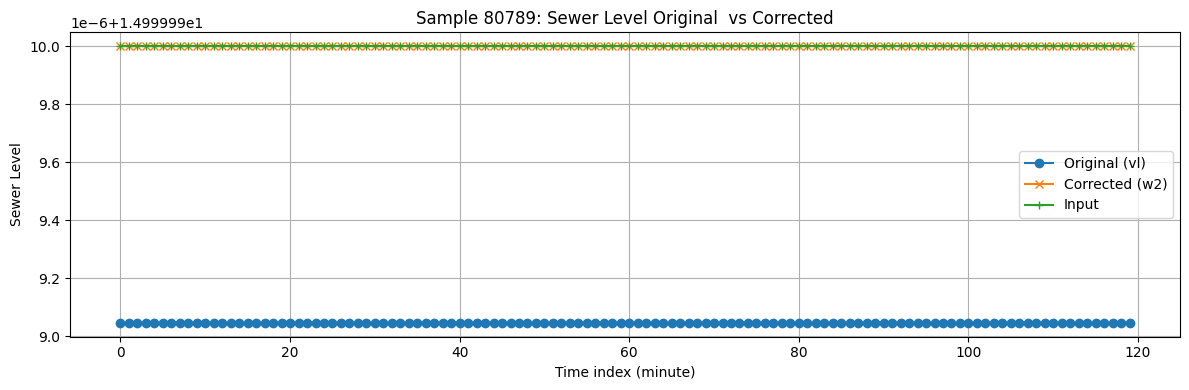

<Figure size 640x480 with 0 Axes>

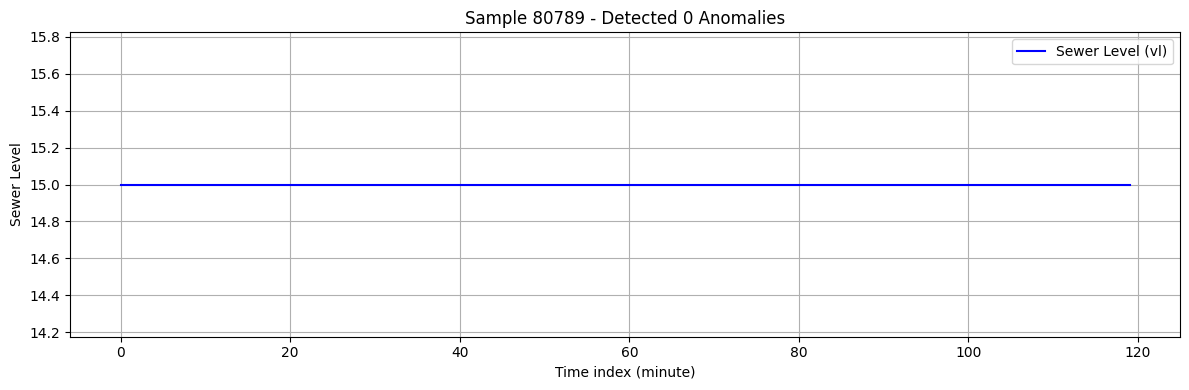

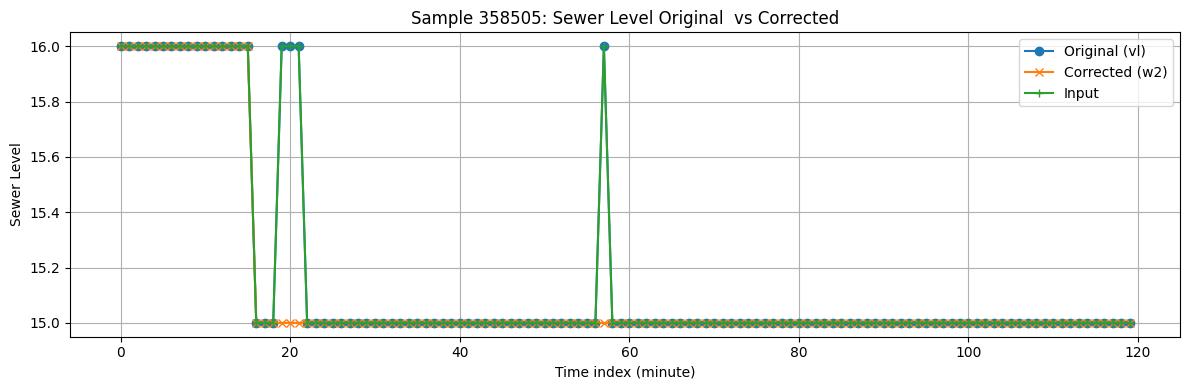

<Figure size 640x480 with 0 Axes>

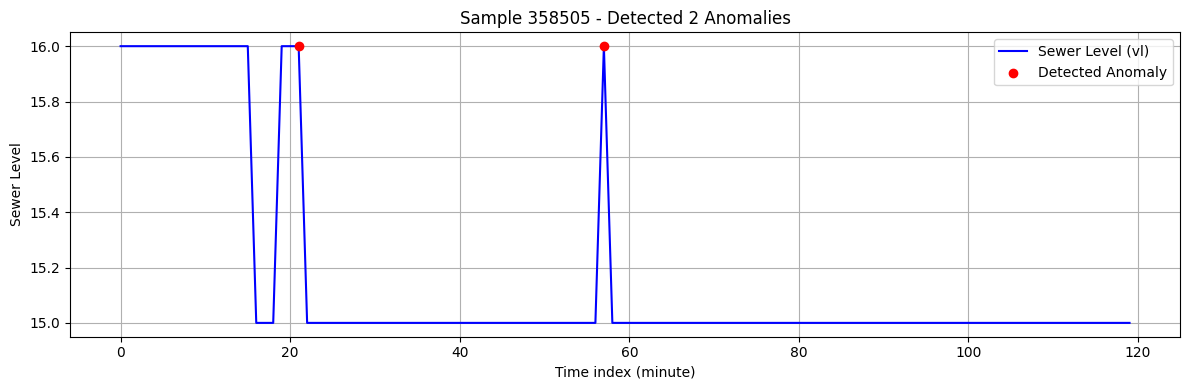

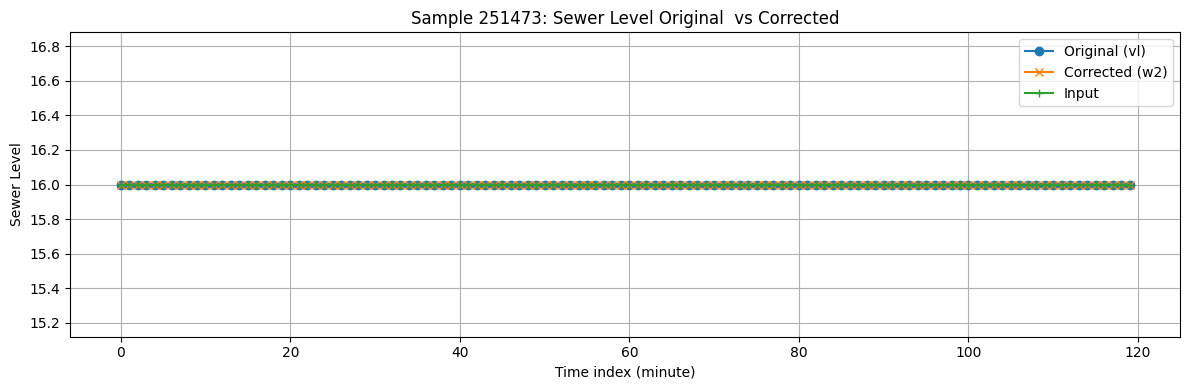

<Figure size 640x480 with 0 Axes>

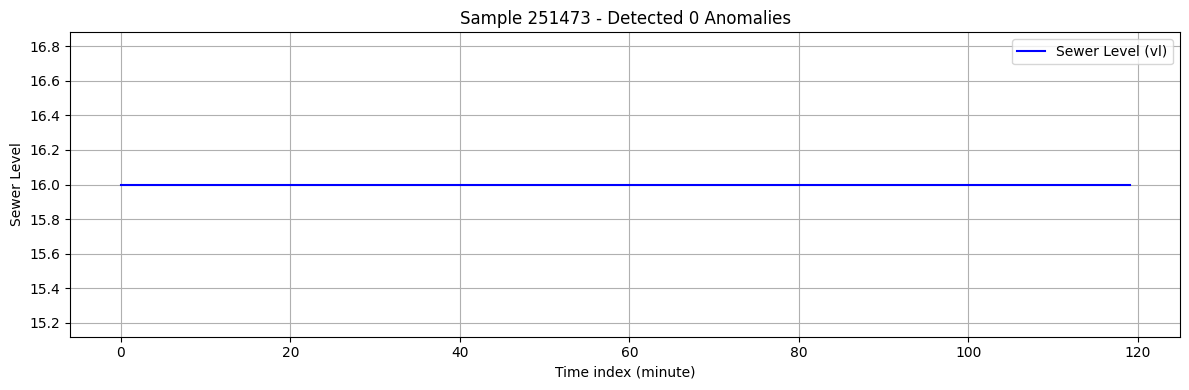

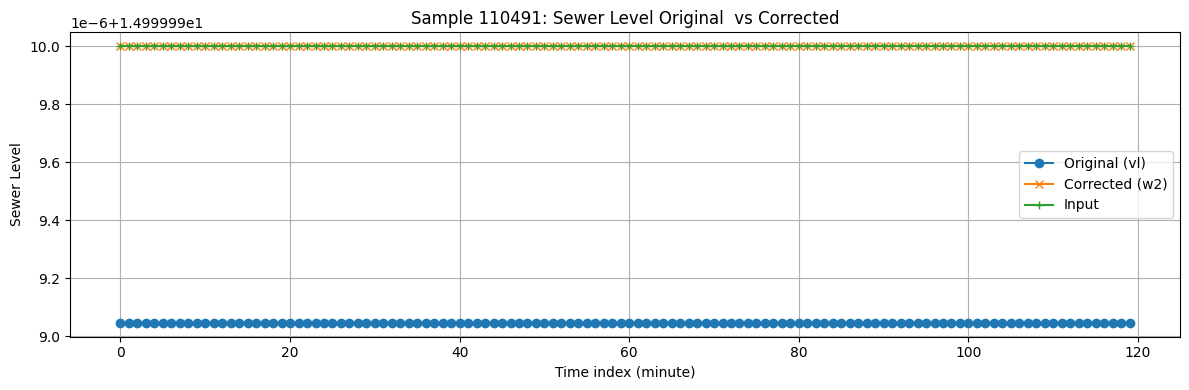

<Figure size 640x480 with 0 Axes>

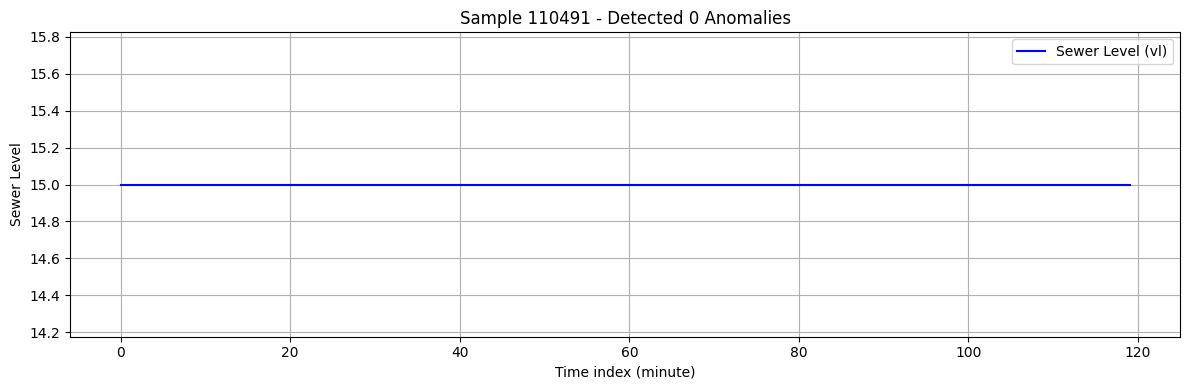

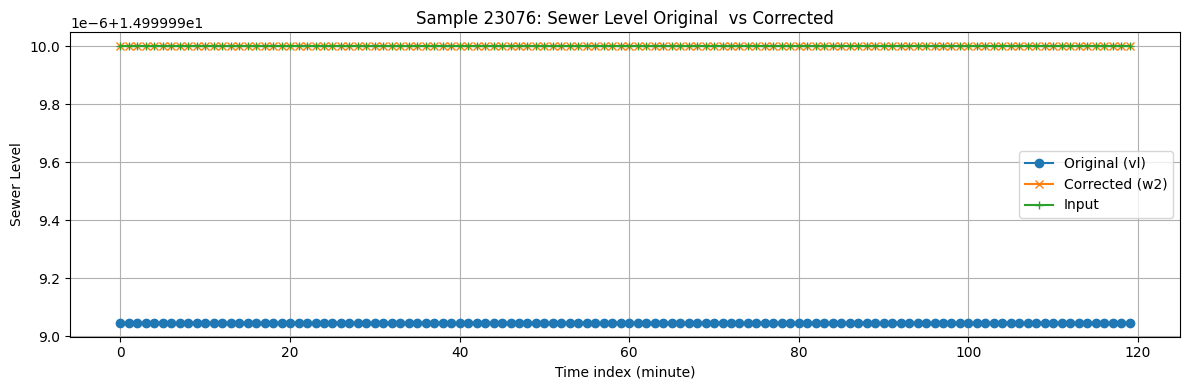

<Figure size 640x480 with 0 Axes>

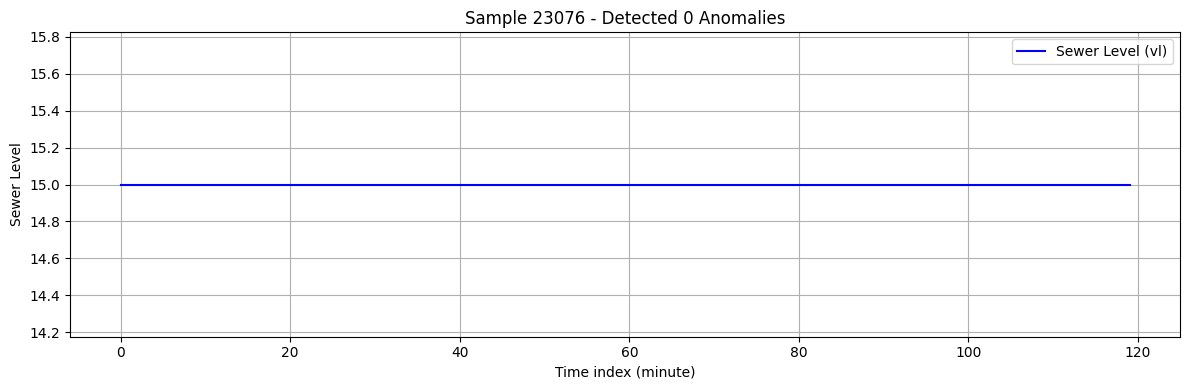

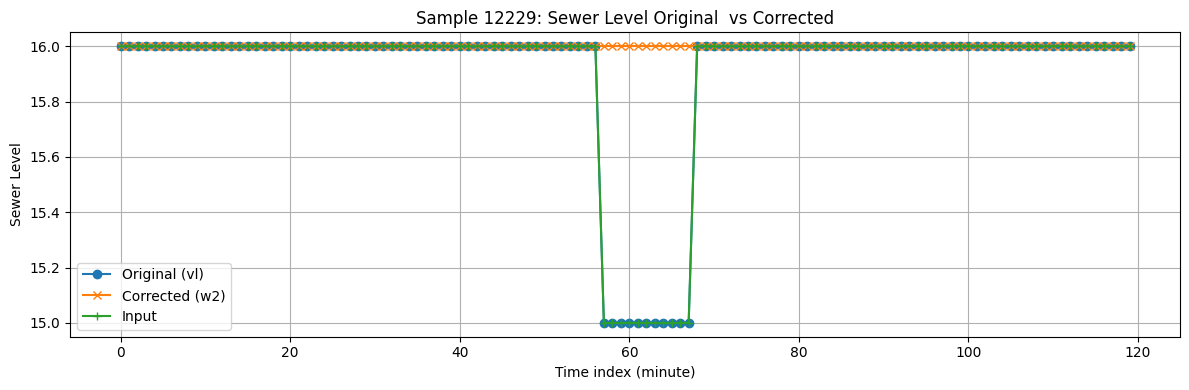

<Figure size 640x480 with 0 Axes>

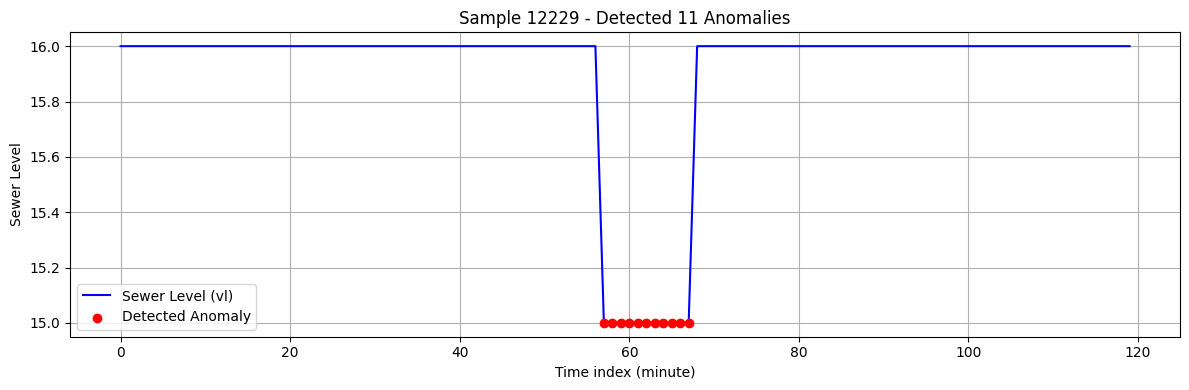

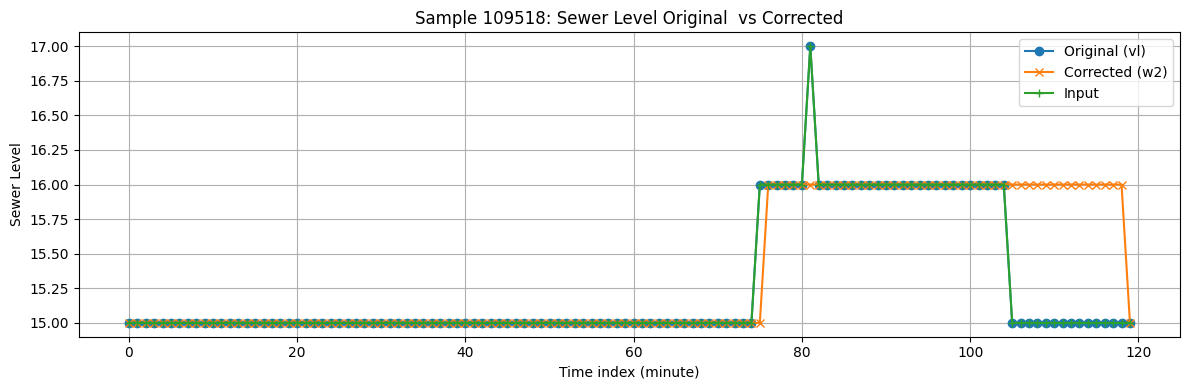

<Figure size 640x480 with 0 Axes>

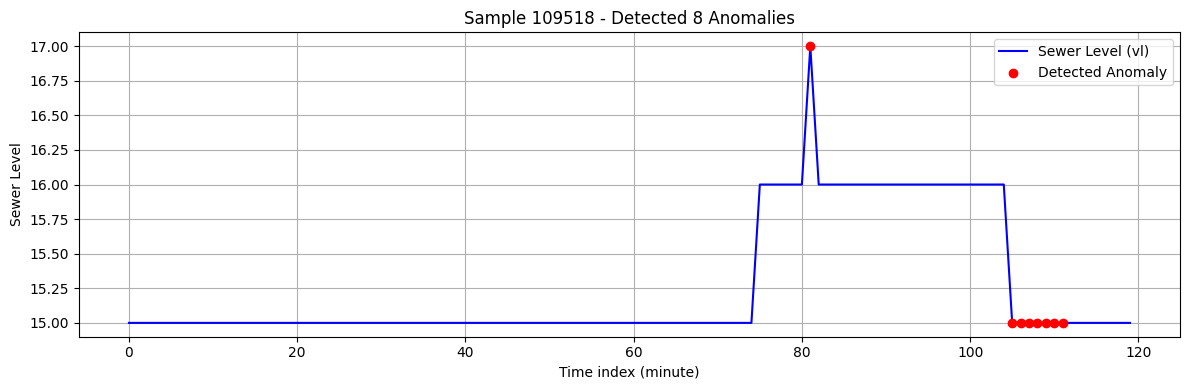

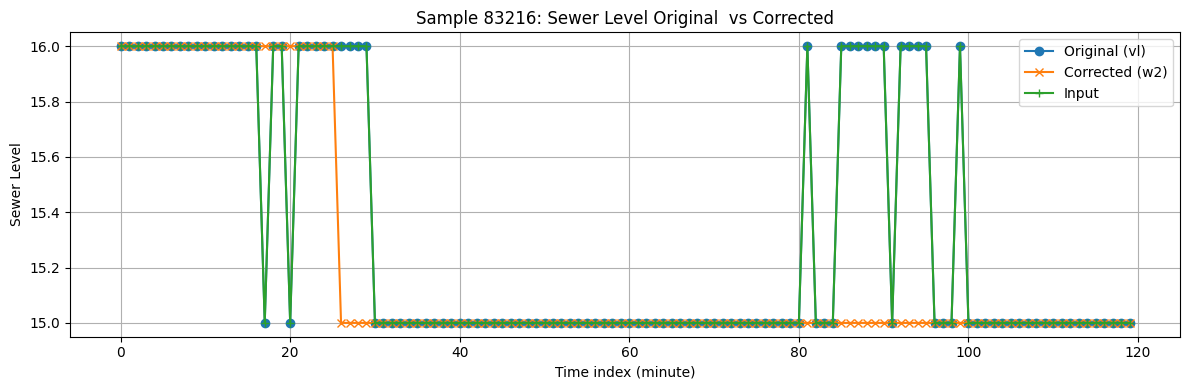

<Figure size 640x480 with 0 Axes>

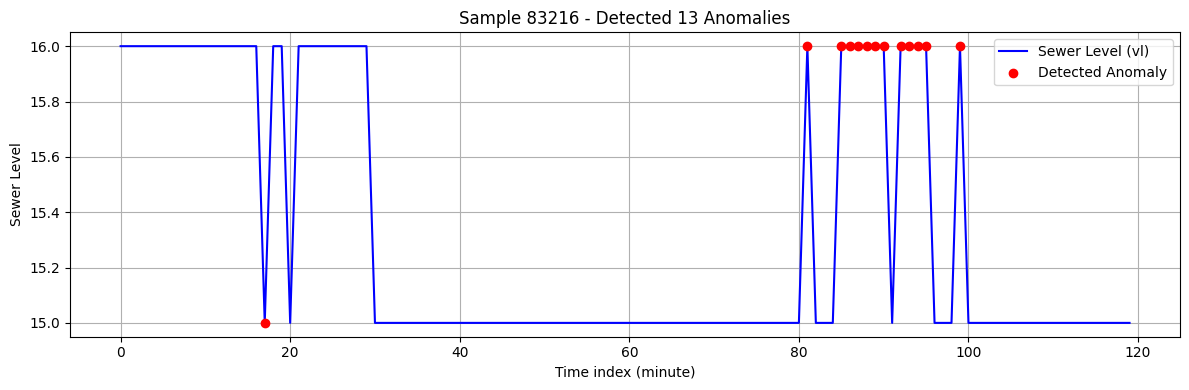

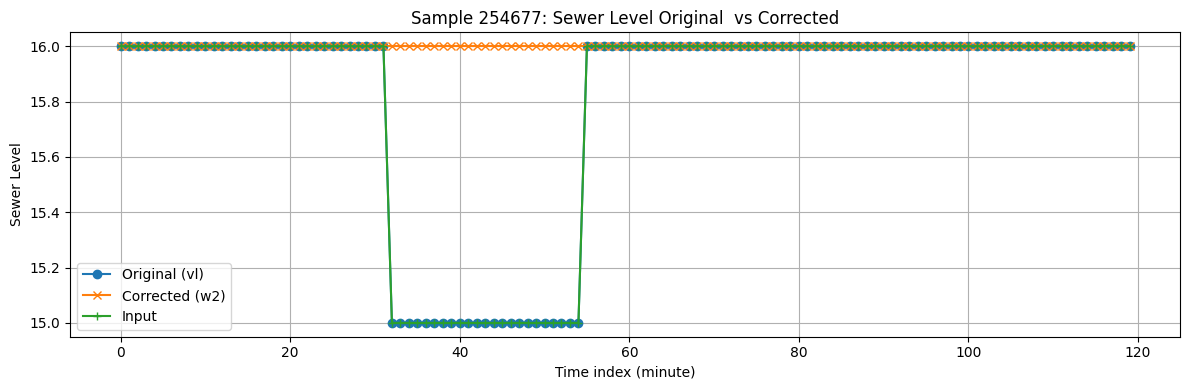

<Figure size 640x480 with 0 Axes>

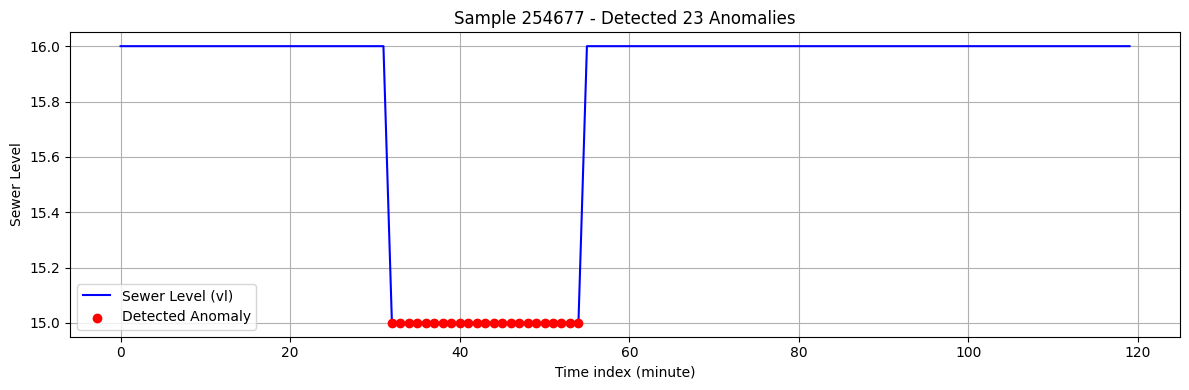

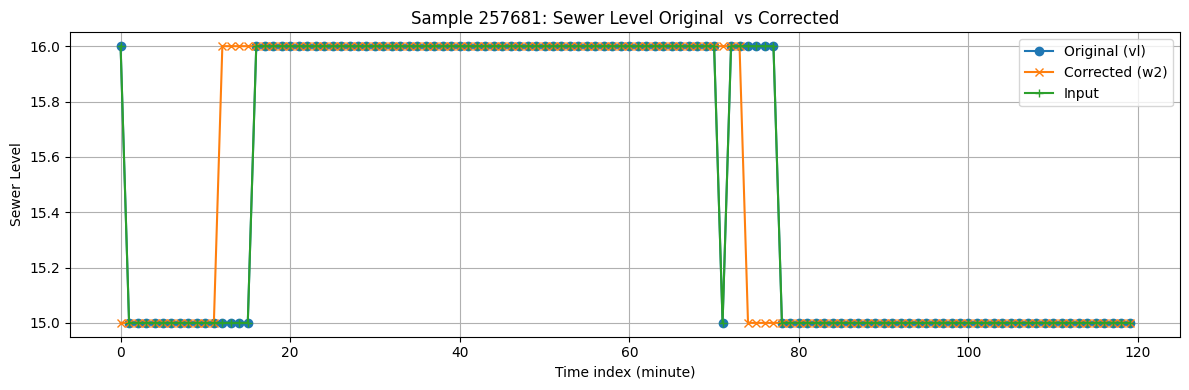

<Figure size 640x480 with 0 Axes>

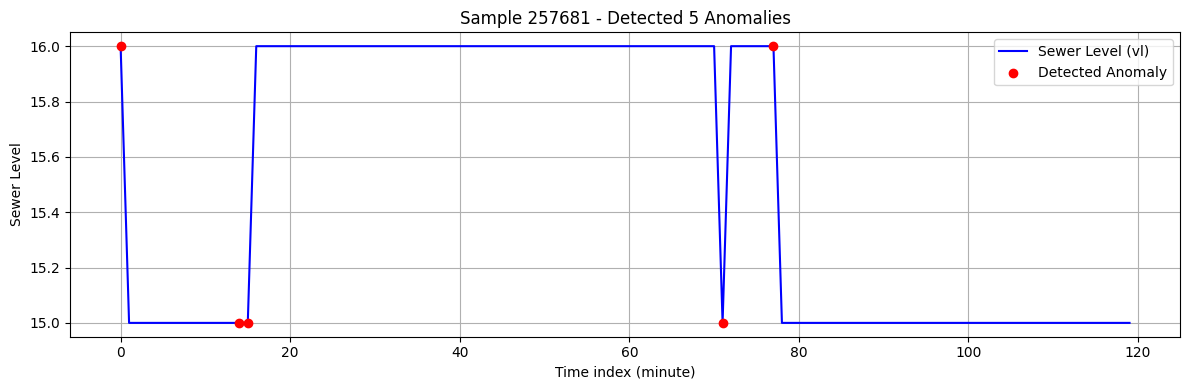

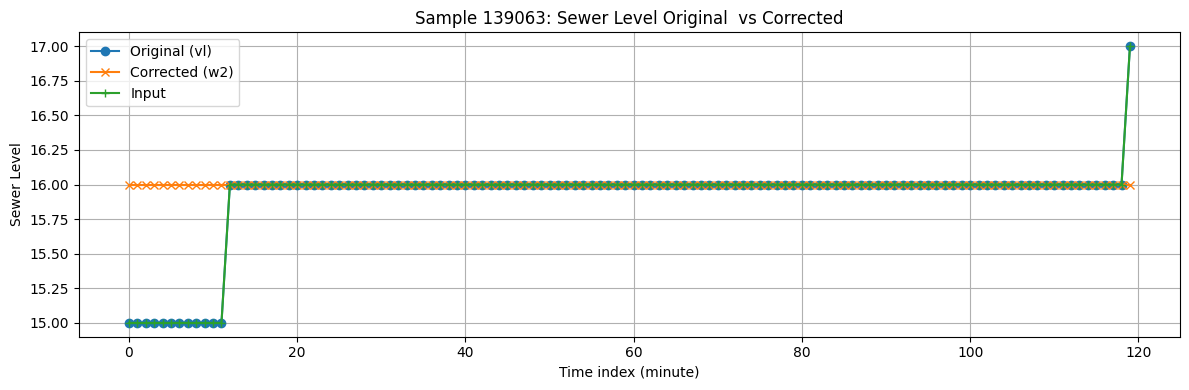

<Figure size 640x480 with 0 Axes>

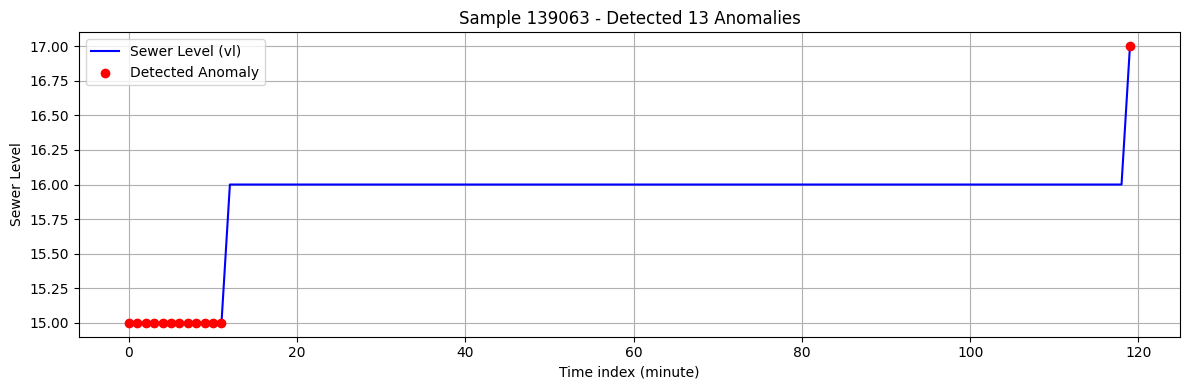

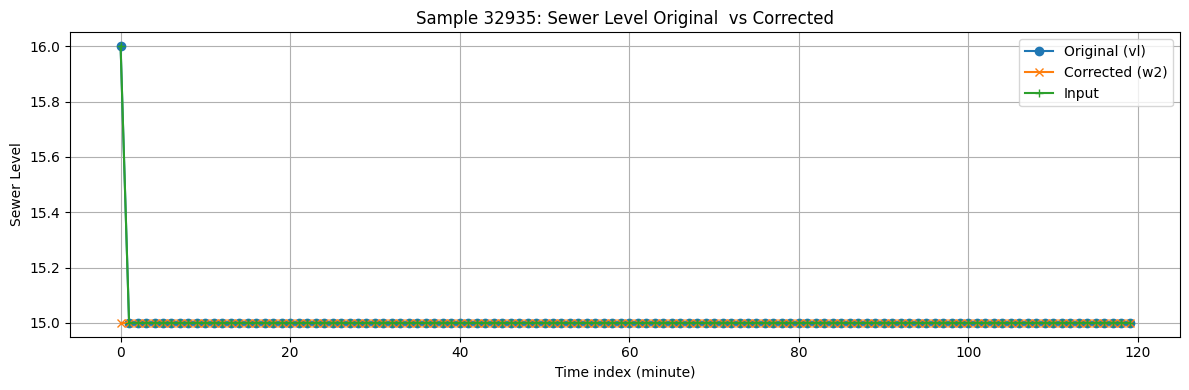

<Figure size 640x480 with 0 Axes>

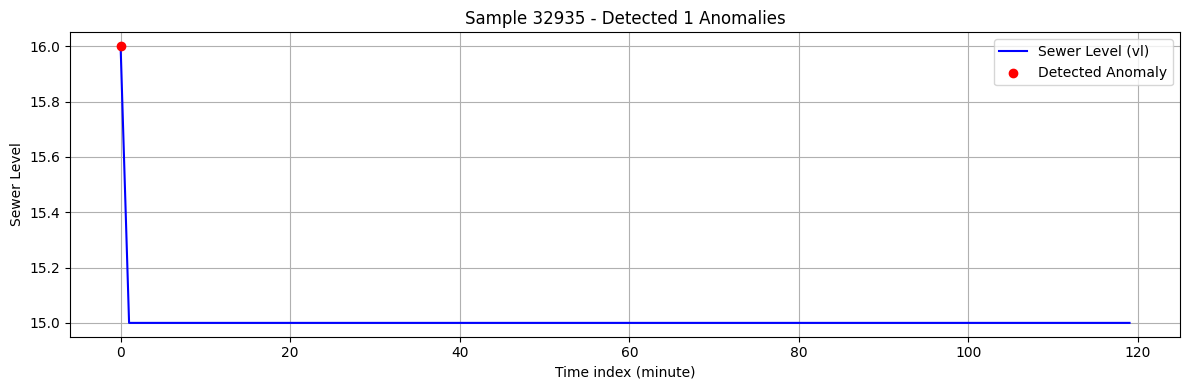

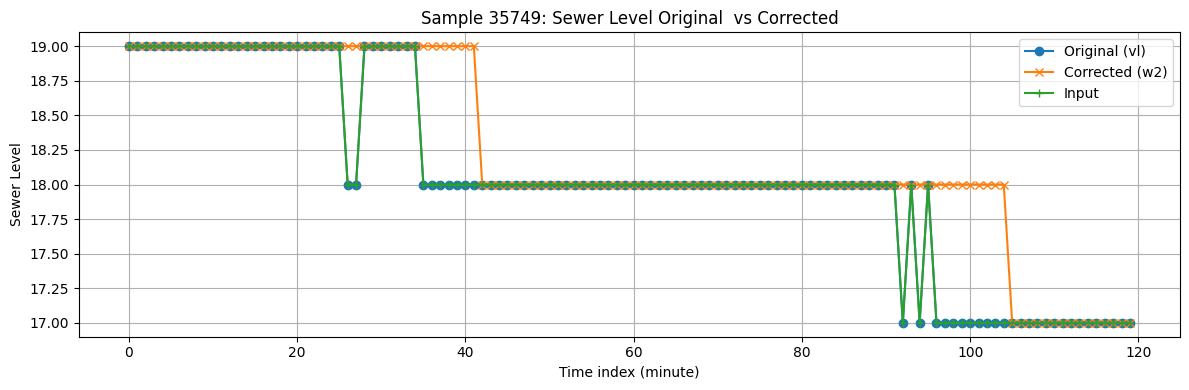

<Figure size 640x480 with 0 Axes>

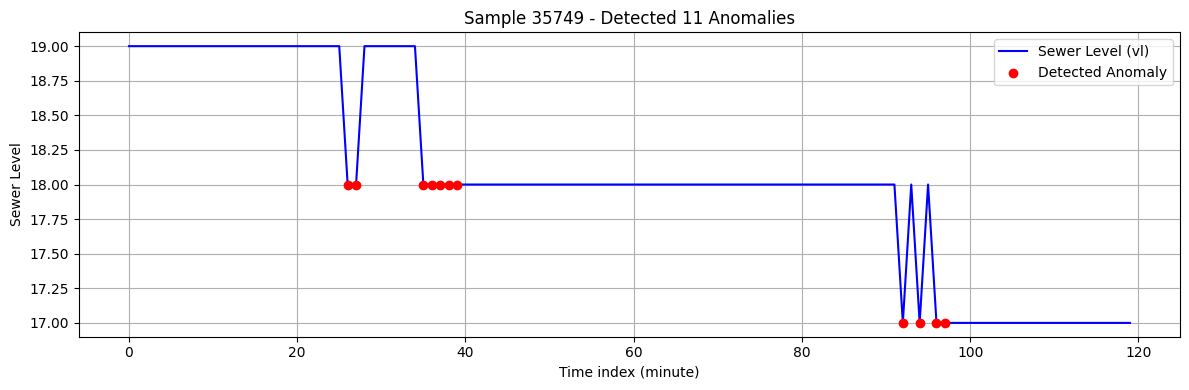

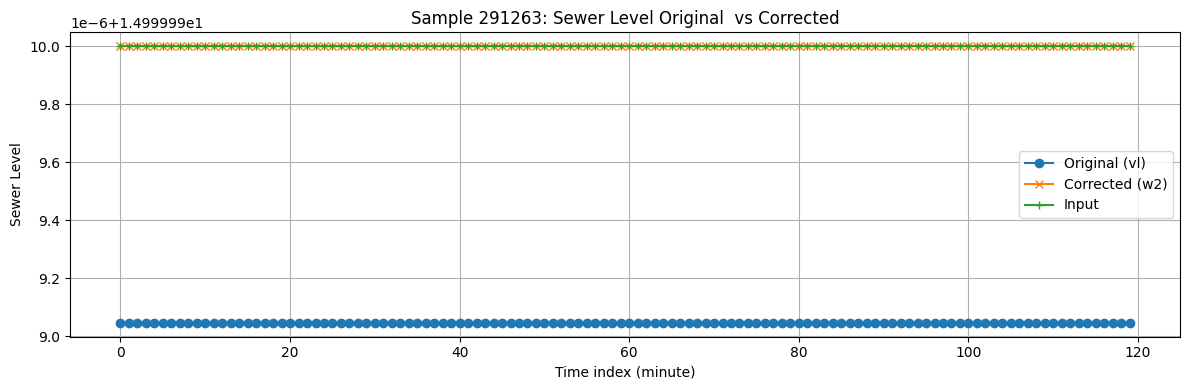

<Figure size 640x480 with 0 Axes>

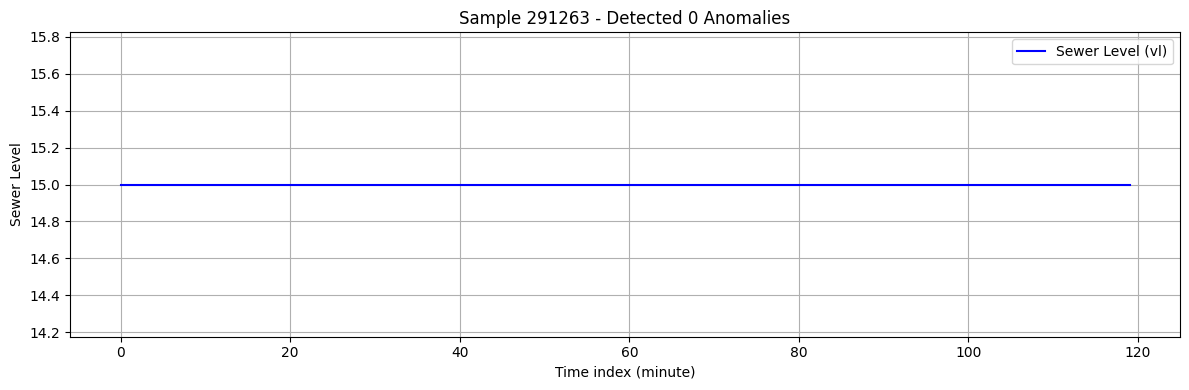

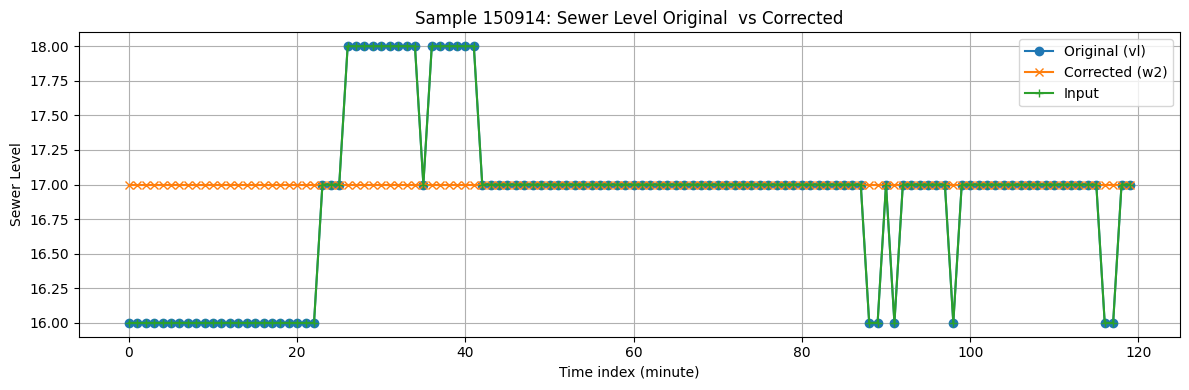

<Figure size 640x480 with 0 Axes>

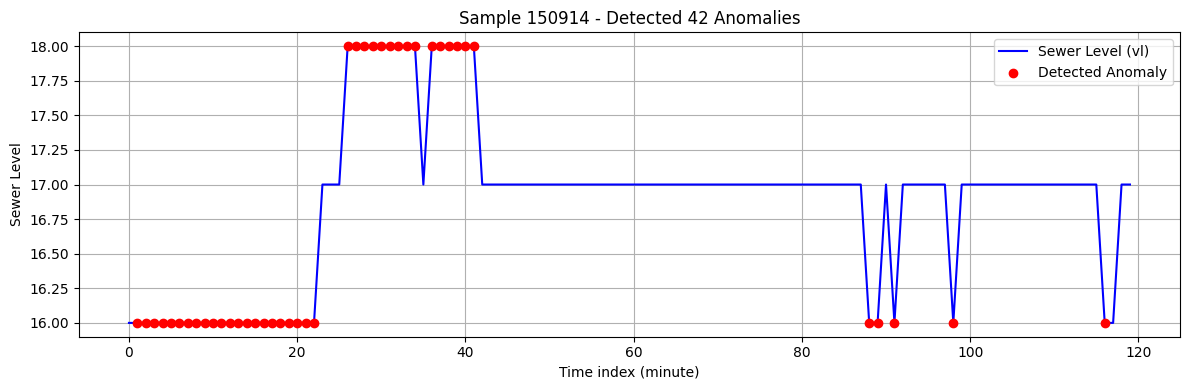

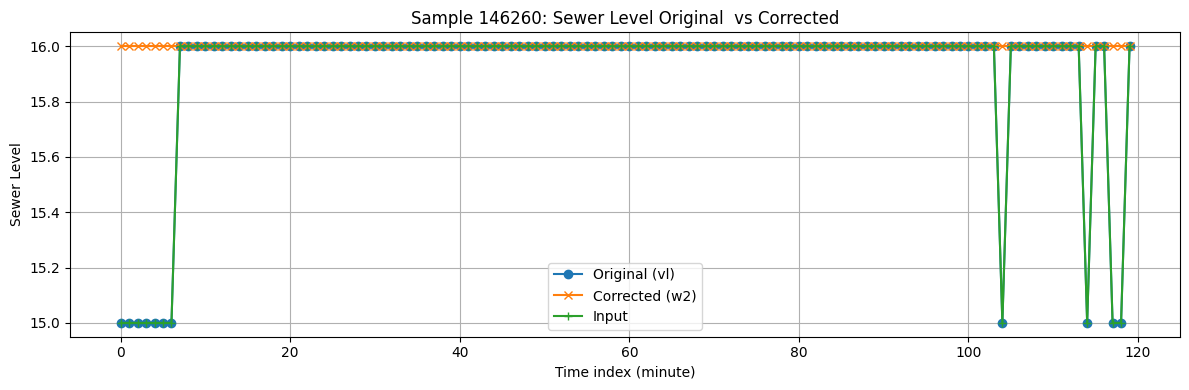

<Figure size 640x480 with 0 Axes>

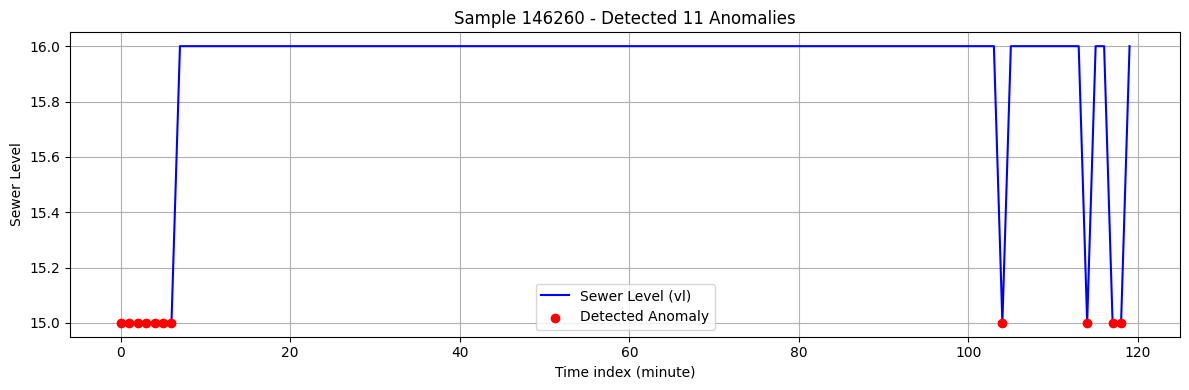

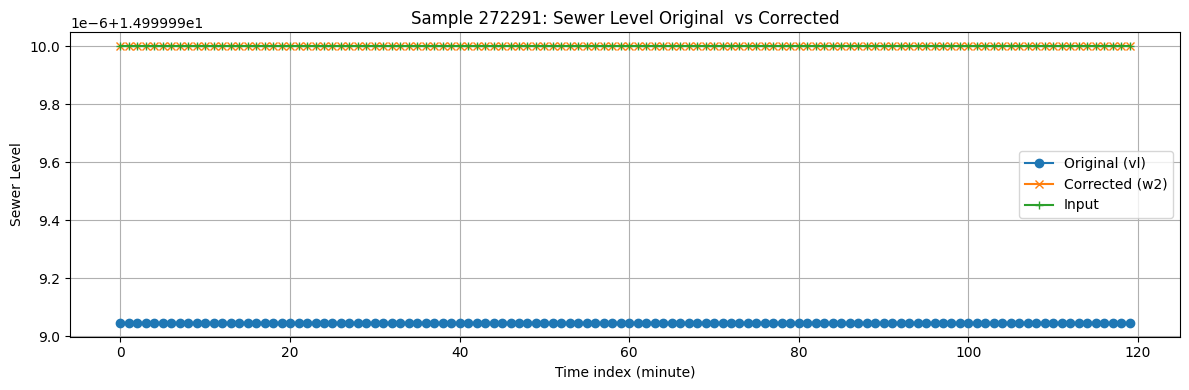

<Figure size 640x480 with 0 Axes>

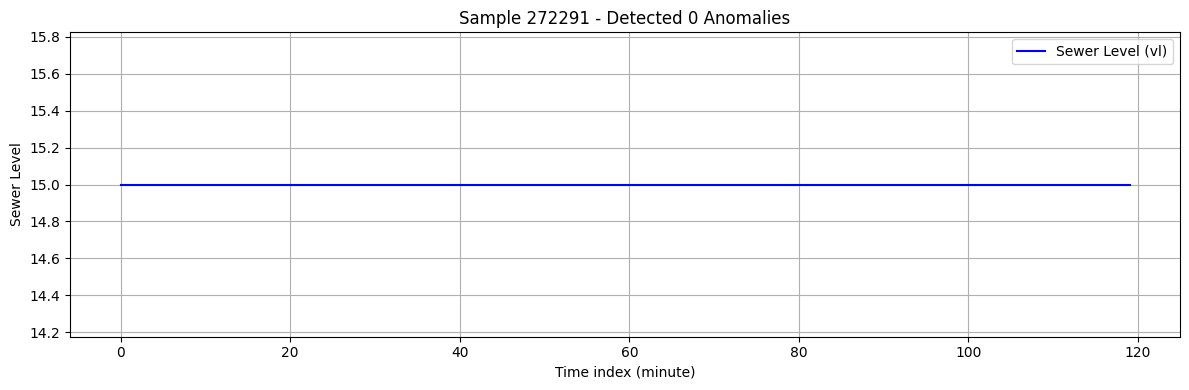

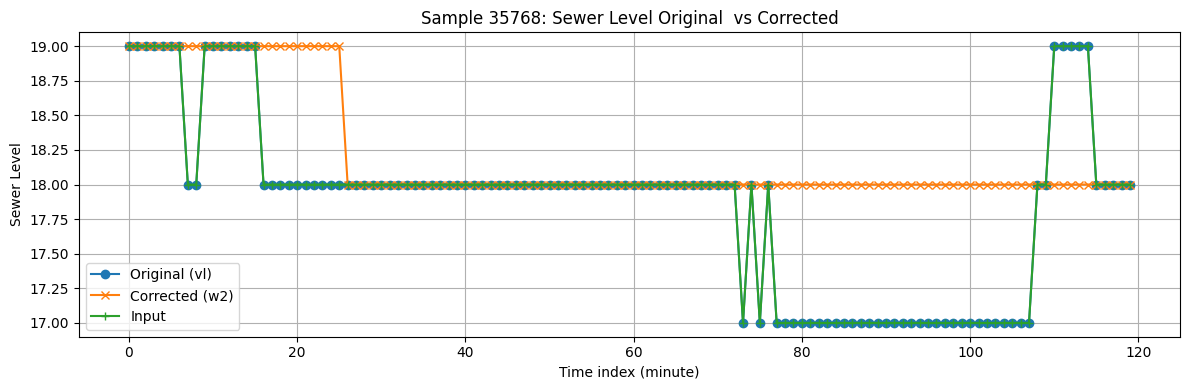

<Figure size 640x480 with 0 Axes>

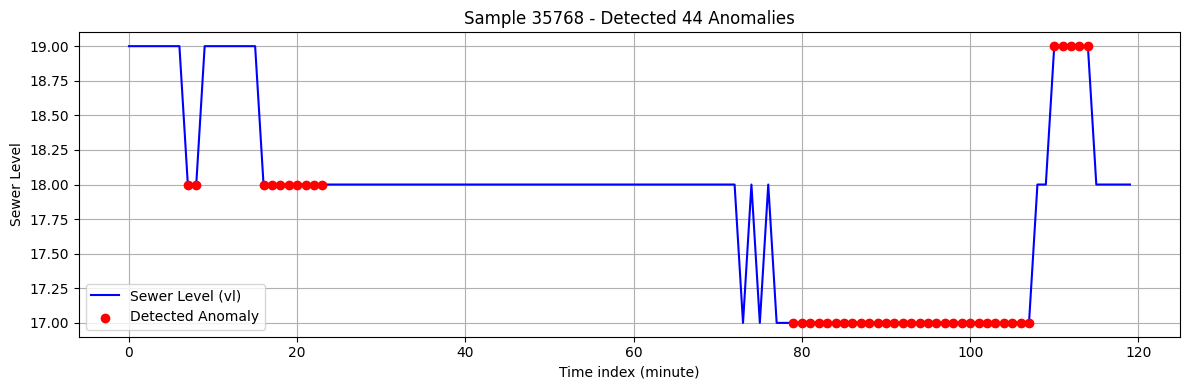

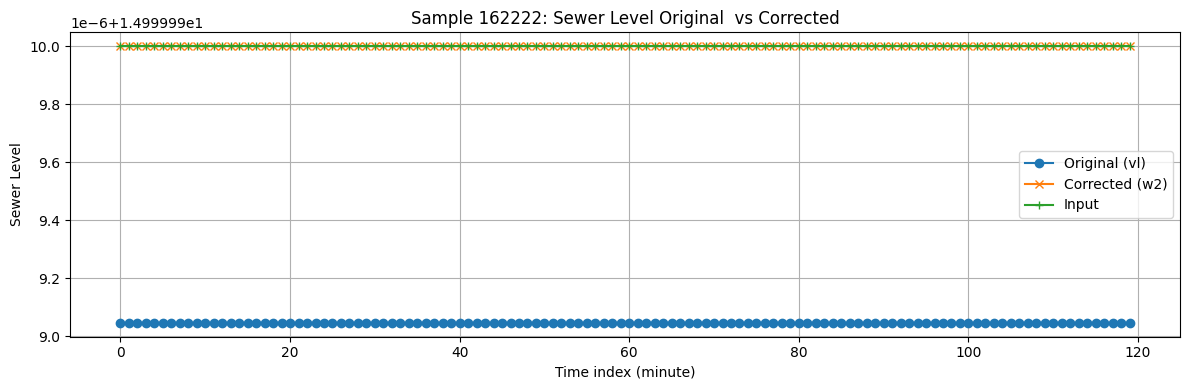

<Figure size 640x480 with 0 Axes>

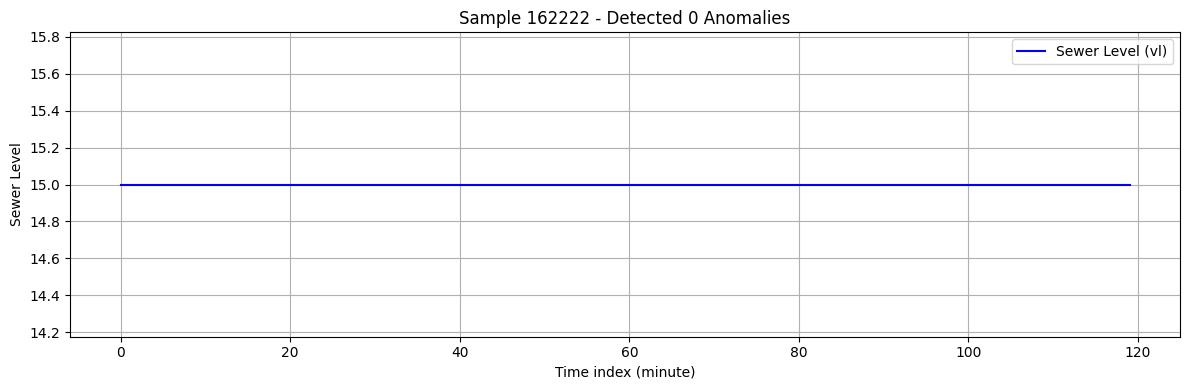

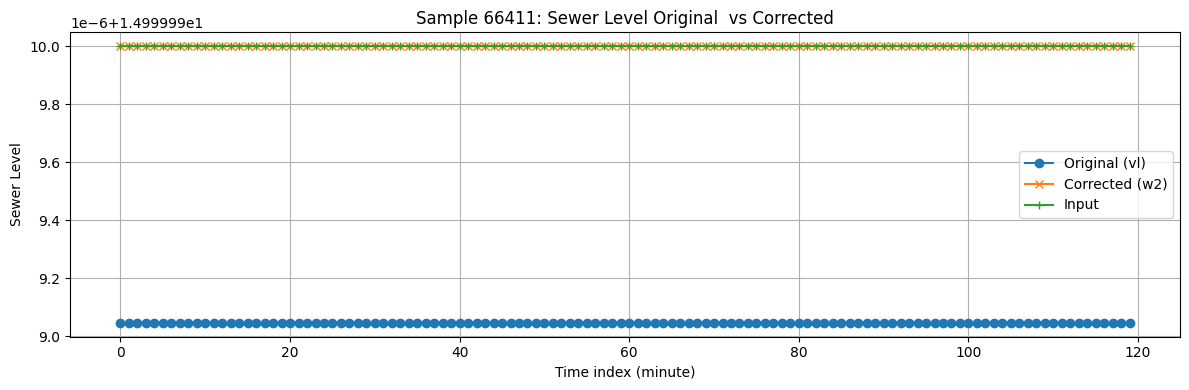

<Figure size 640x480 with 0 Axes>

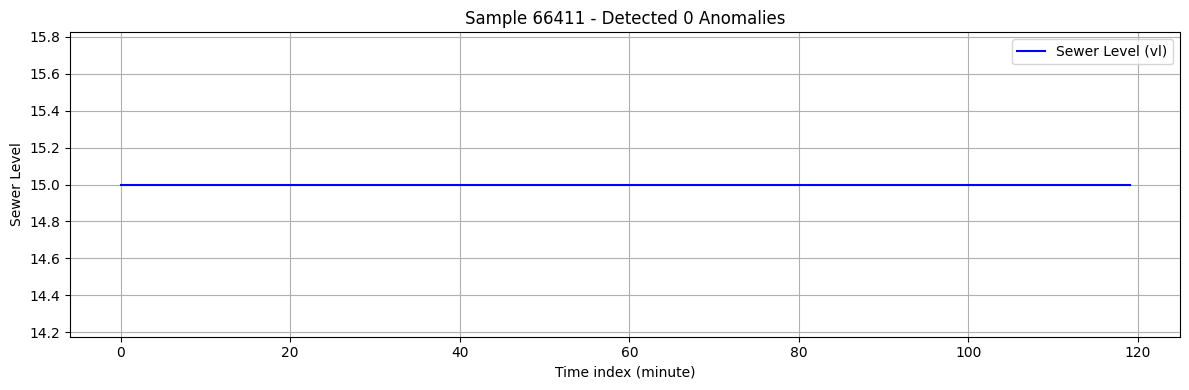

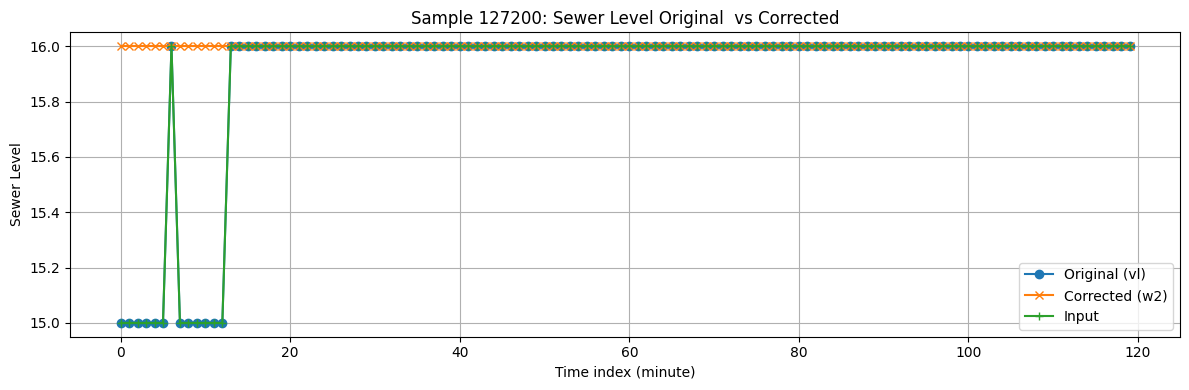

<Figure size 640x480 with 0 Axes>

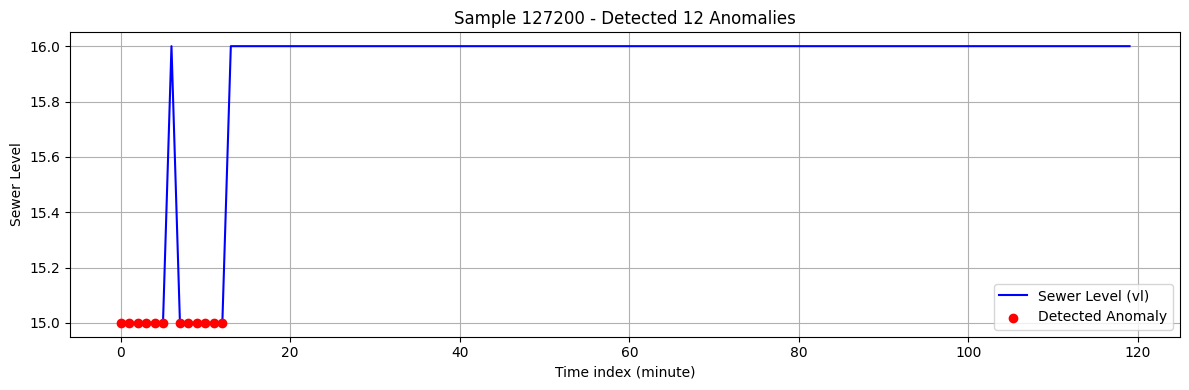

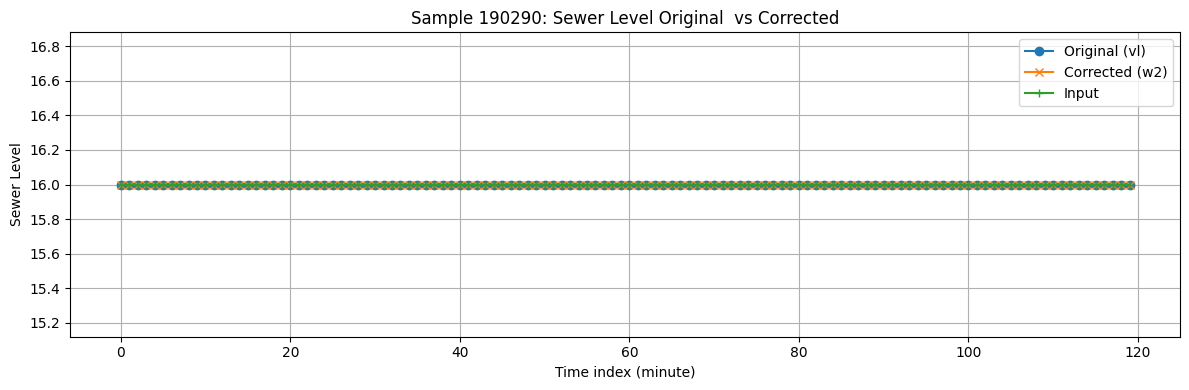

<Figure size 640x480 with 0 Axes>

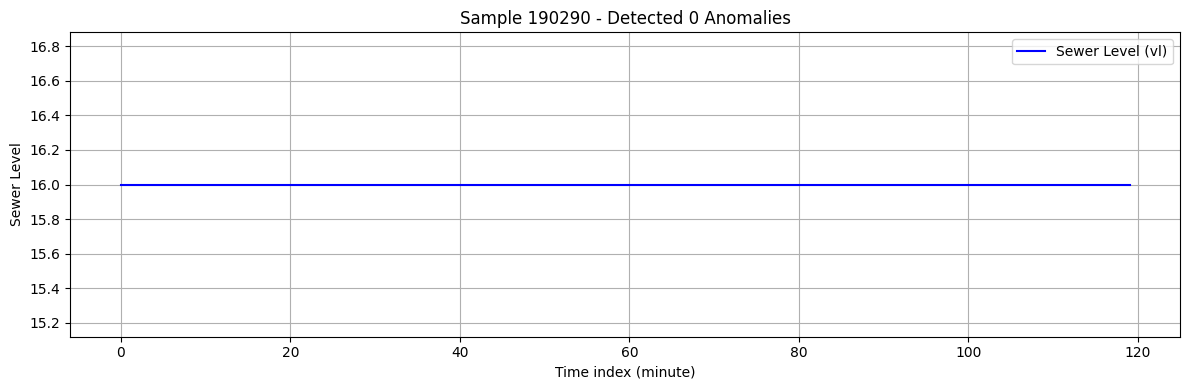

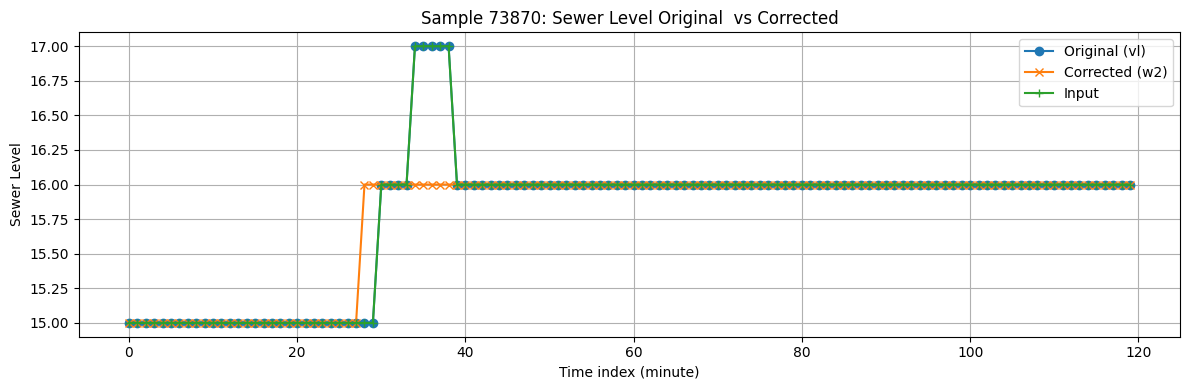

<Figure size 640x480 with 0 Axes>

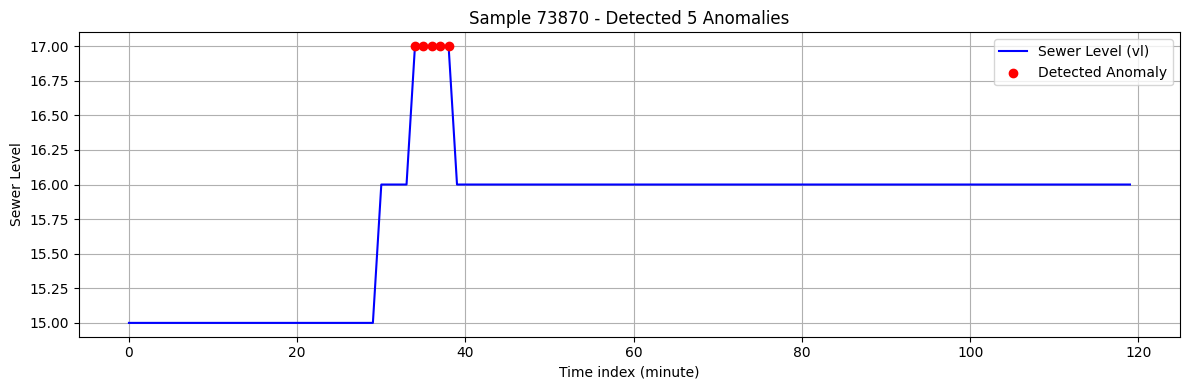

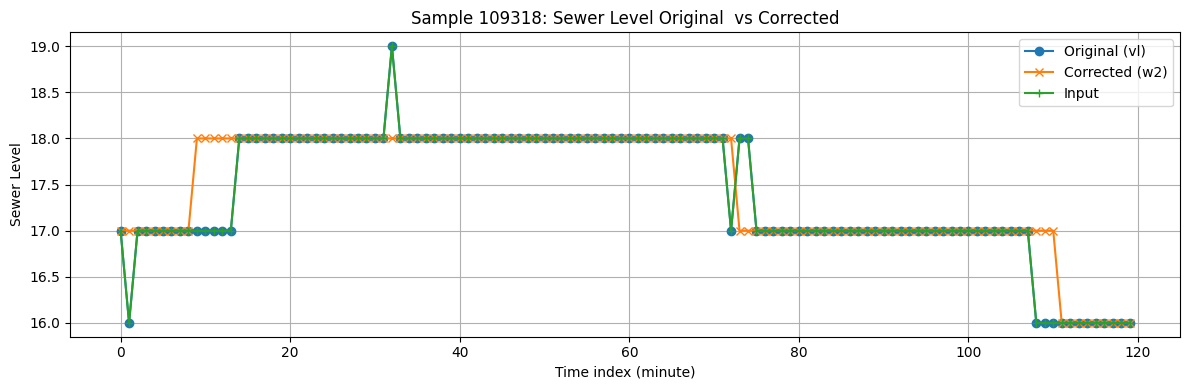

<Figure size 640x480 with 0 Axes>

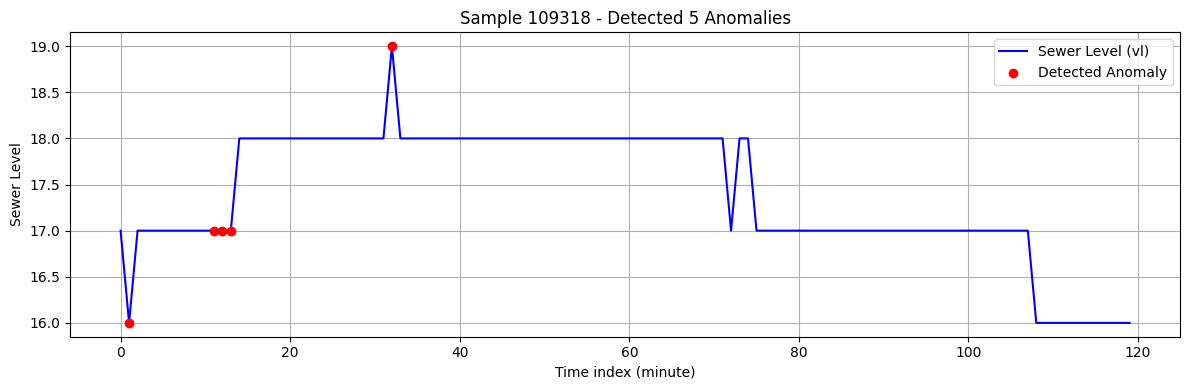

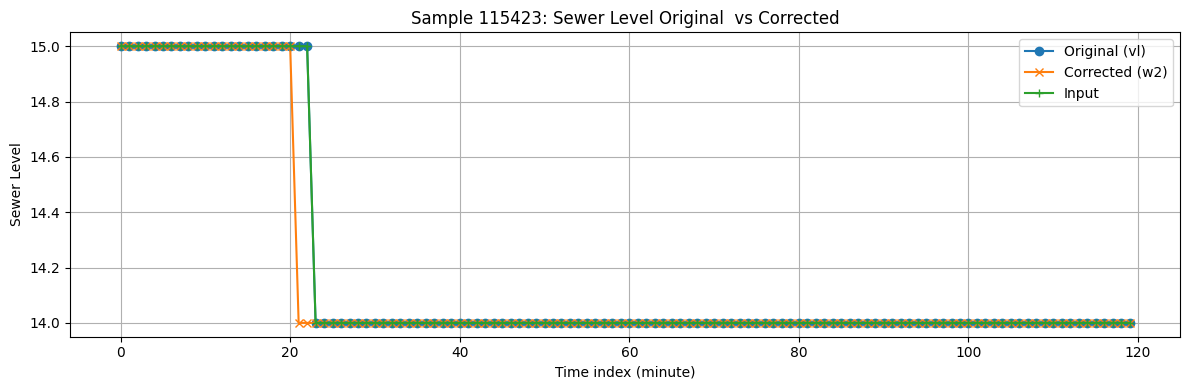

<Figure size 640x480 with 0 Axes>

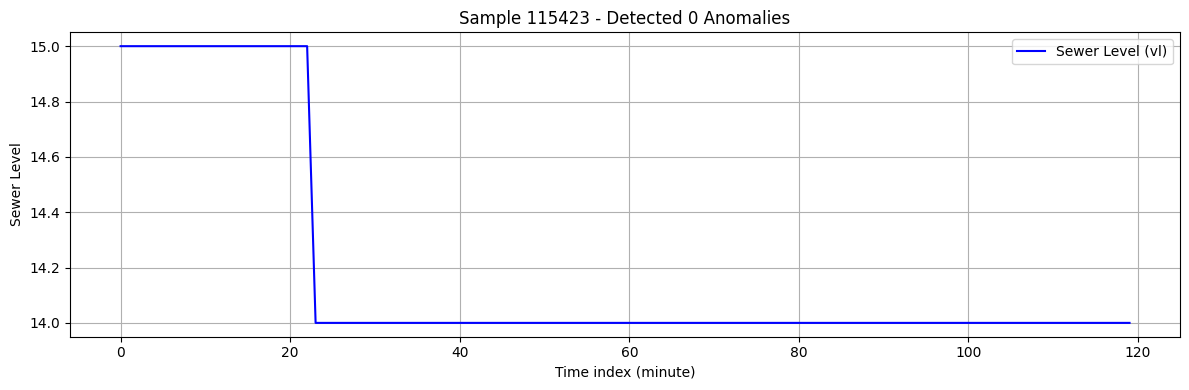

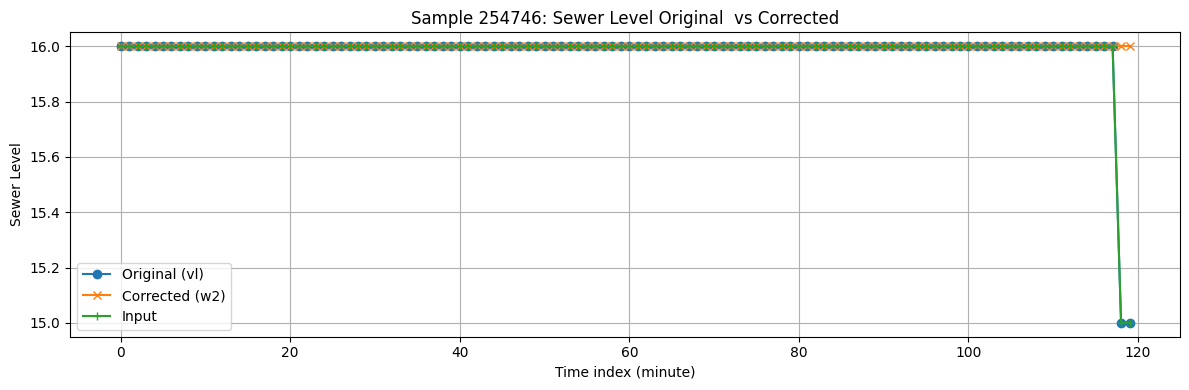

<Figure size 640x480 with 0 Axes>

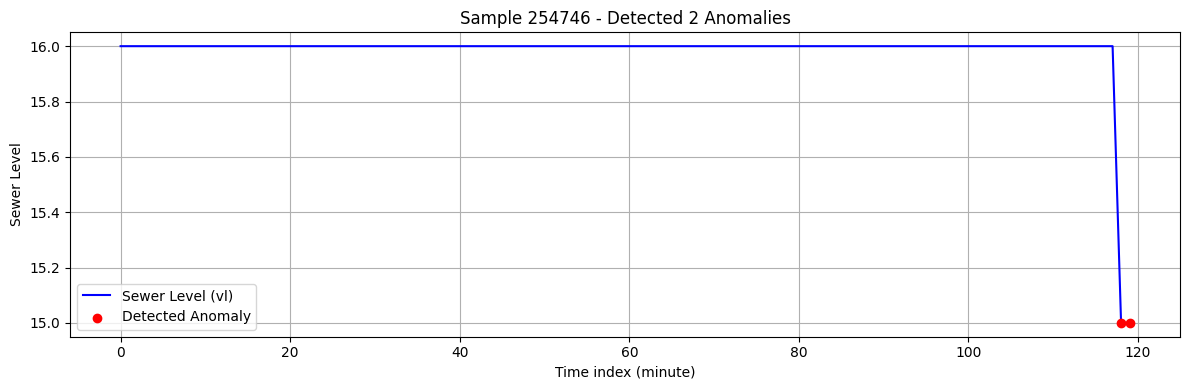

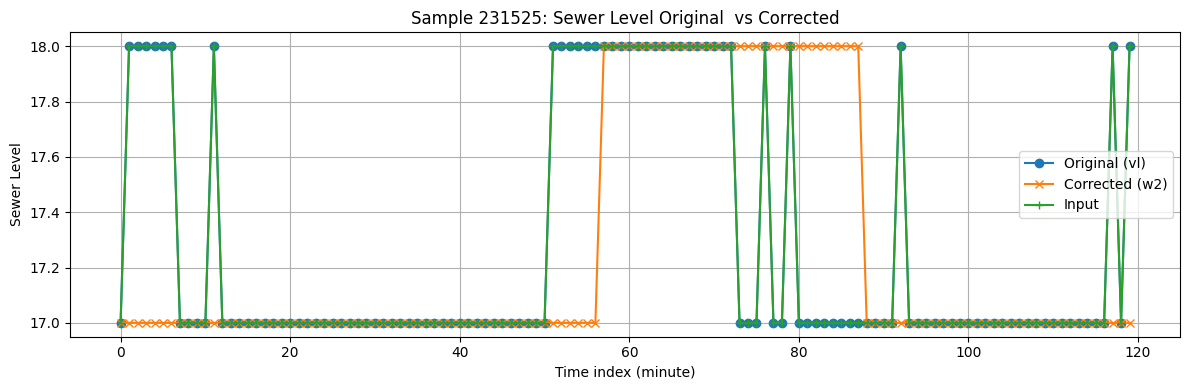

<Figure size 640x480 with 0 Axes>

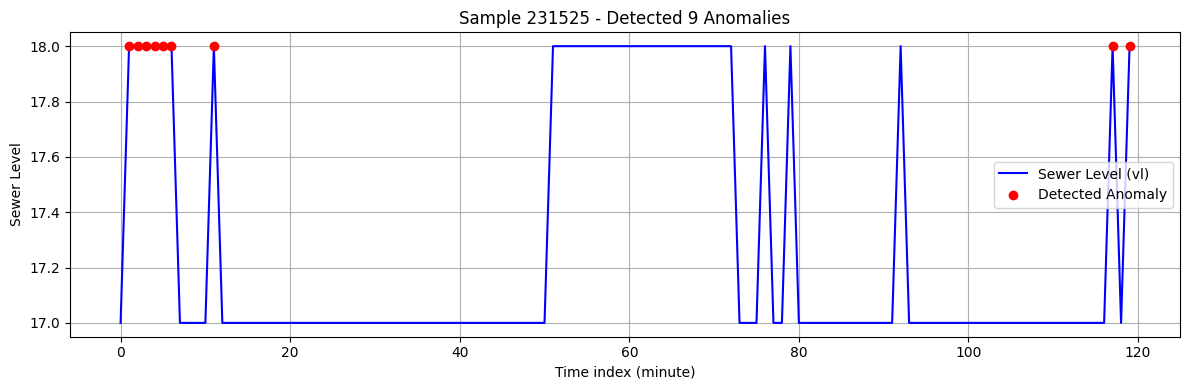

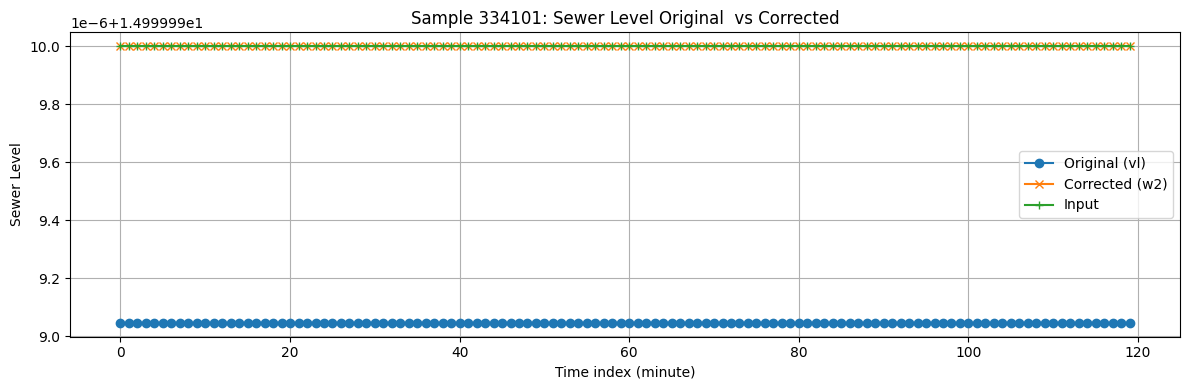

<Figure size 640x480 with 0 Axes>

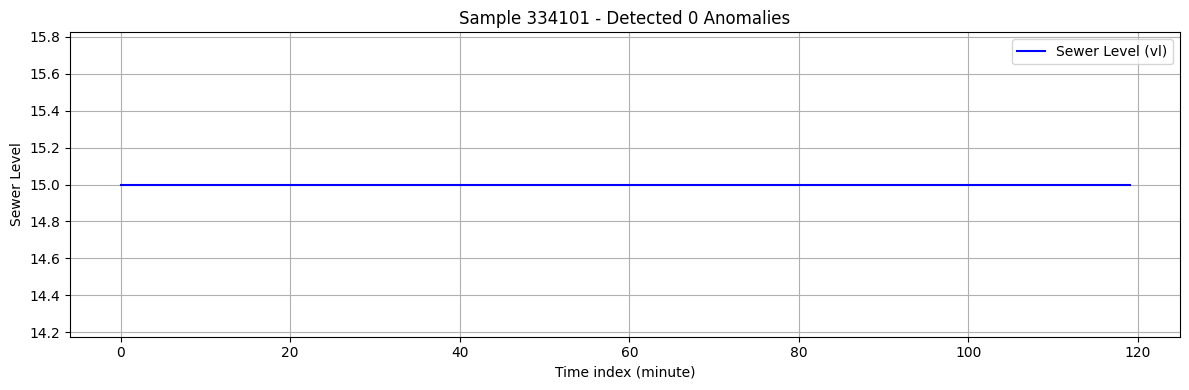

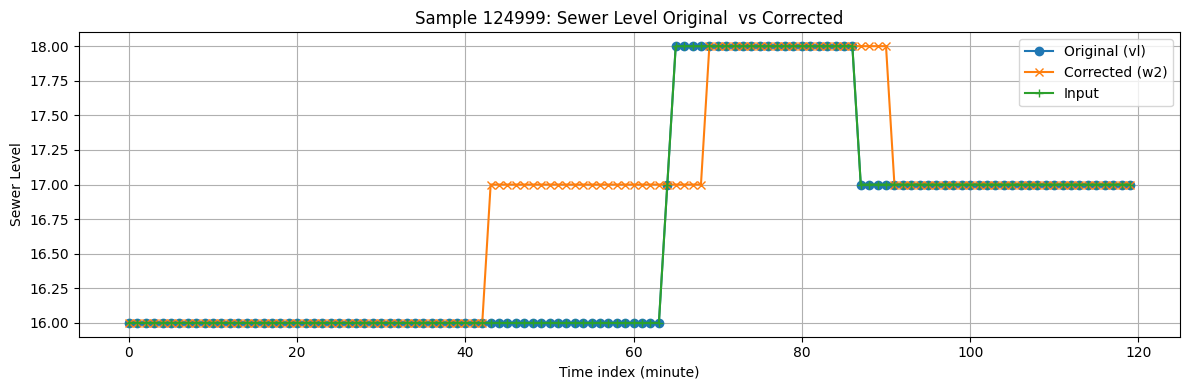

<Figure size 640x480 with 0 Axes>

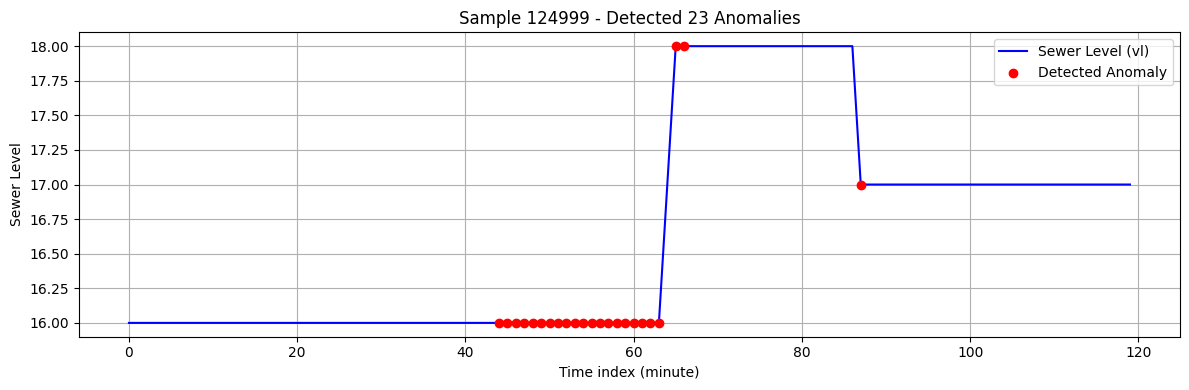

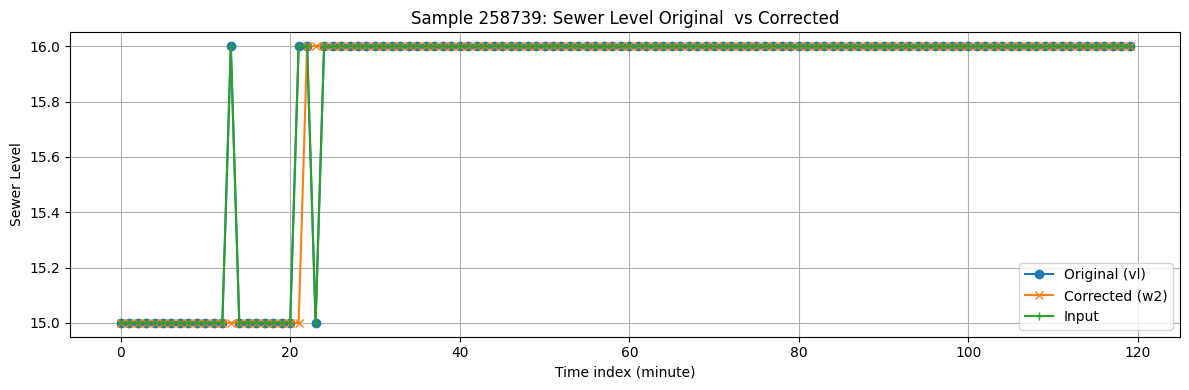

<Figure size 640x480 with 0 Axes>

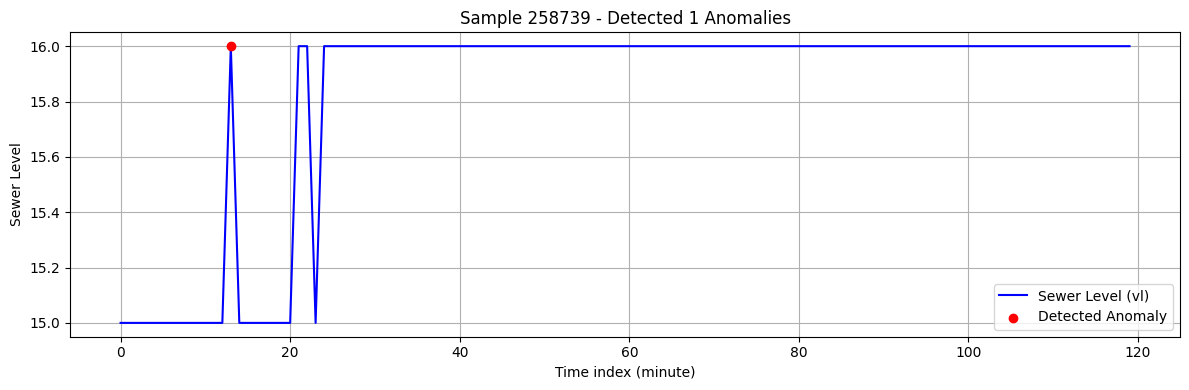

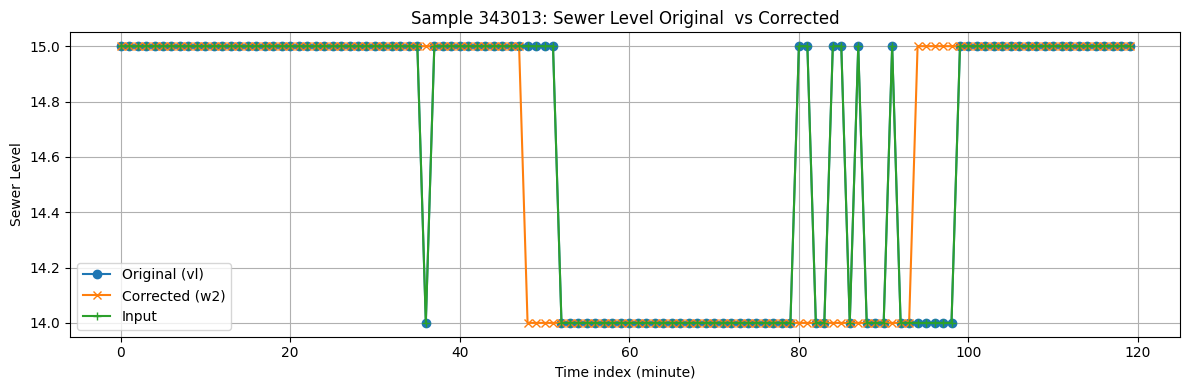

<Figure size 640x480 with 0 Axes>

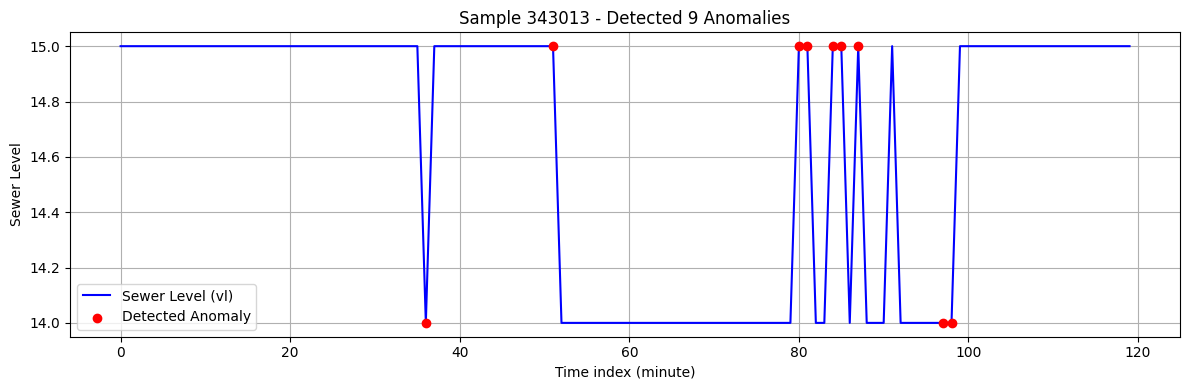

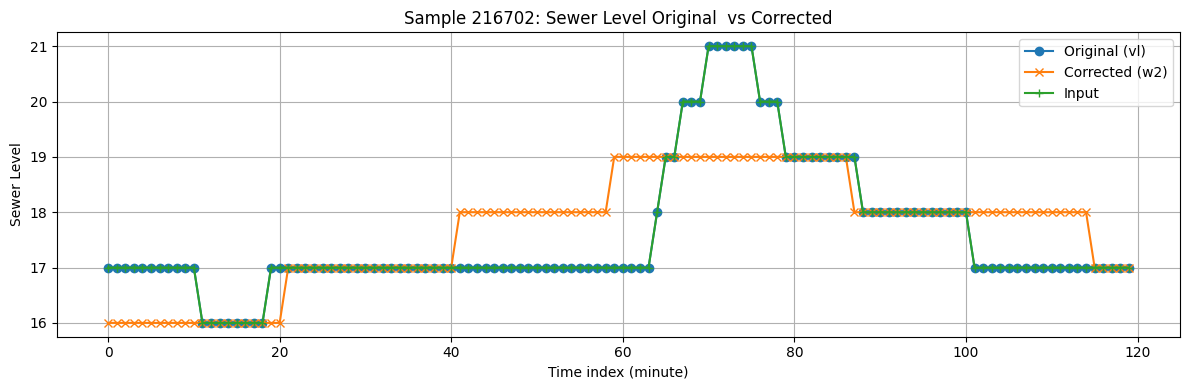

<Figure size 640x480 with 0 Axes>

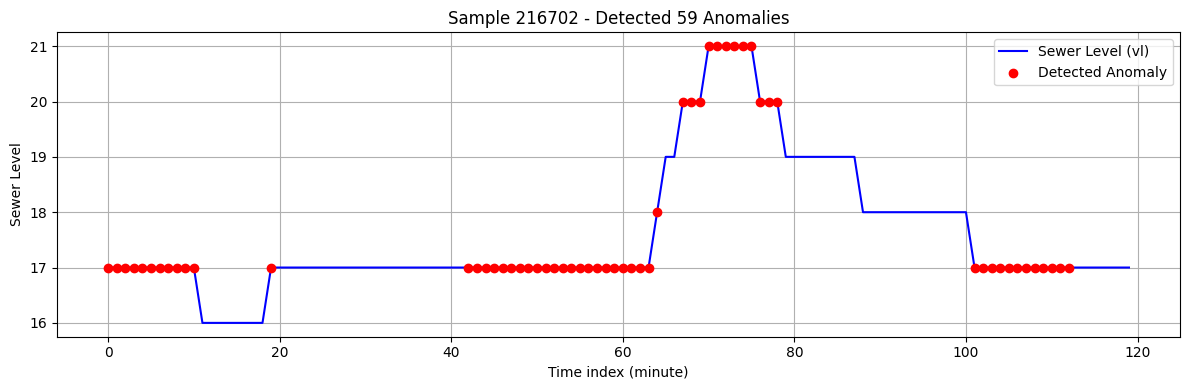

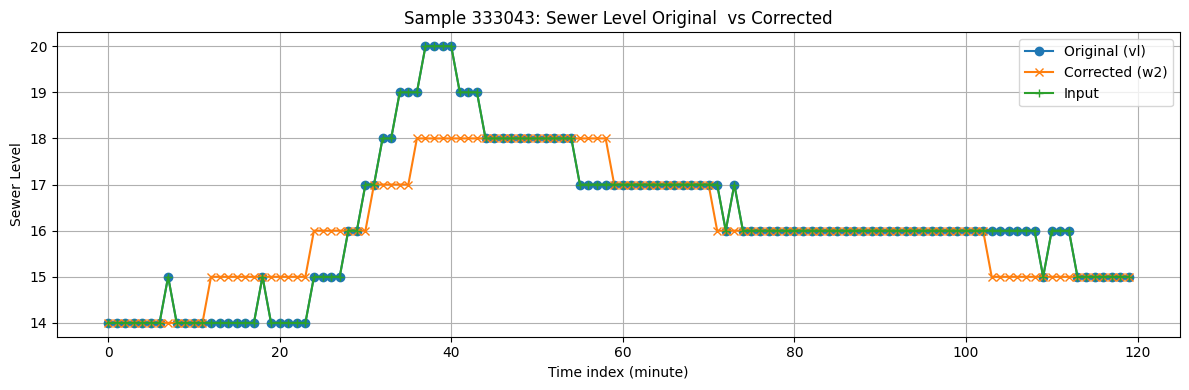

<Figure size 640x480 with 0 Axes>

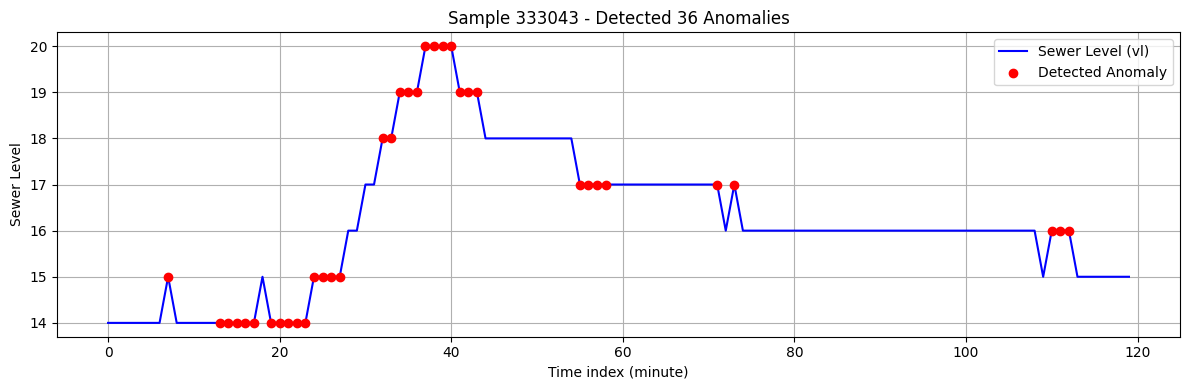

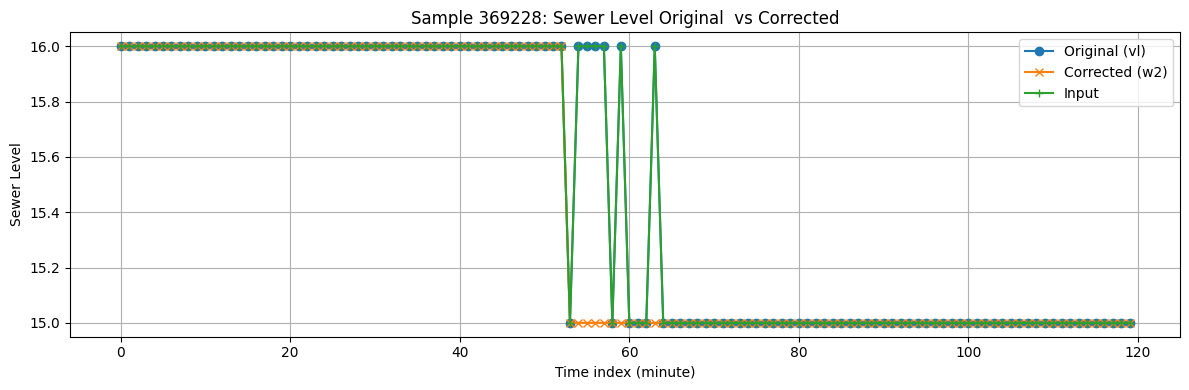

<Figure size 640x480 with 0 Axes>

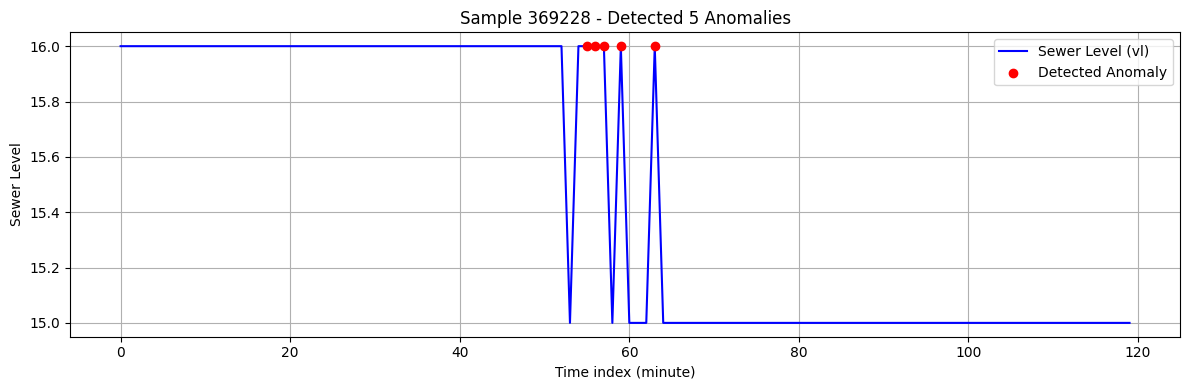

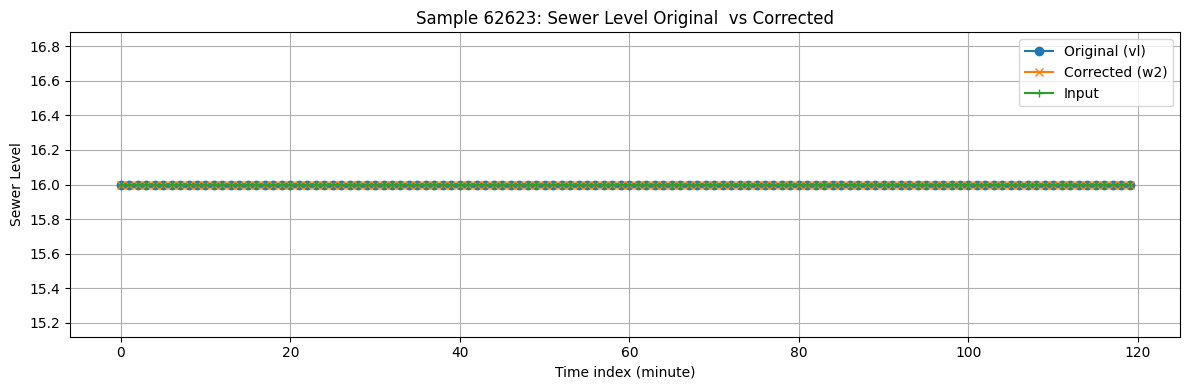

<Figure size 640x480 with 0 Axes>

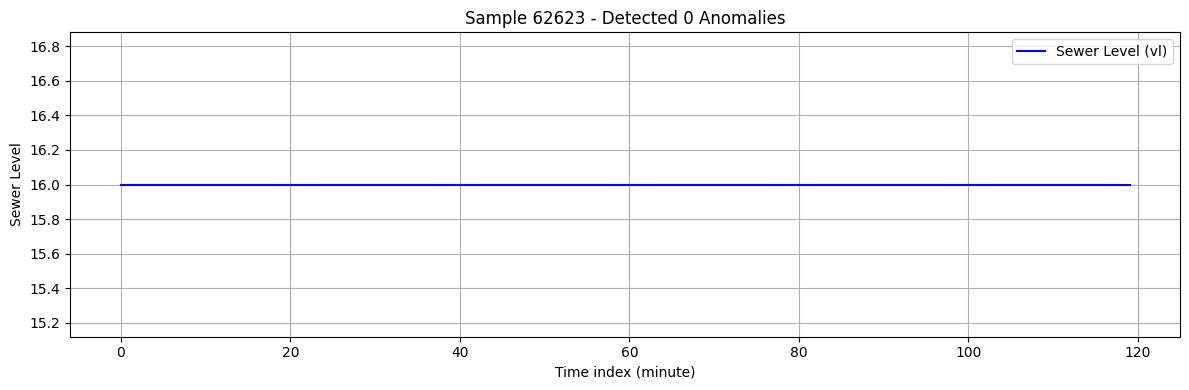

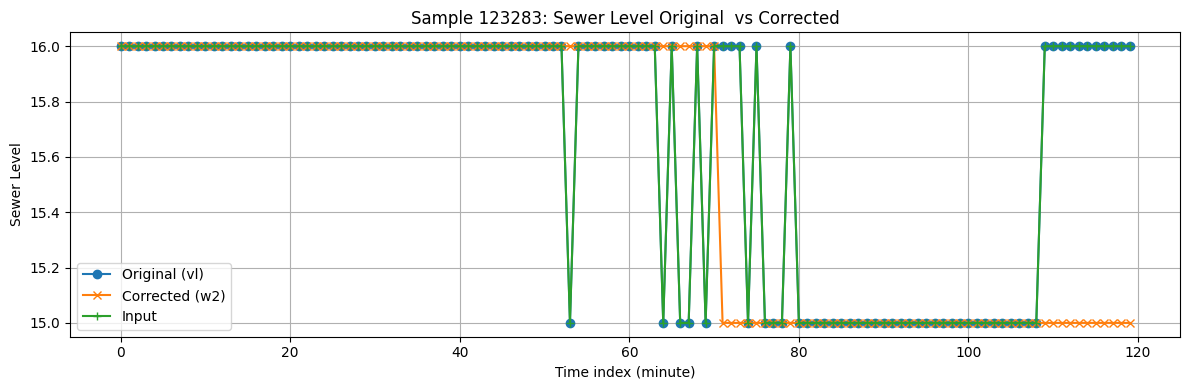

<Figure size 640x480 with 0 Axes>

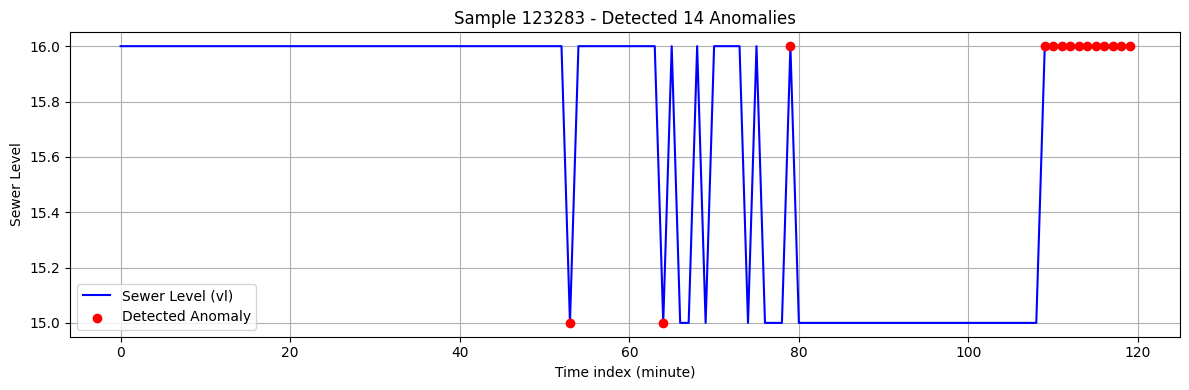

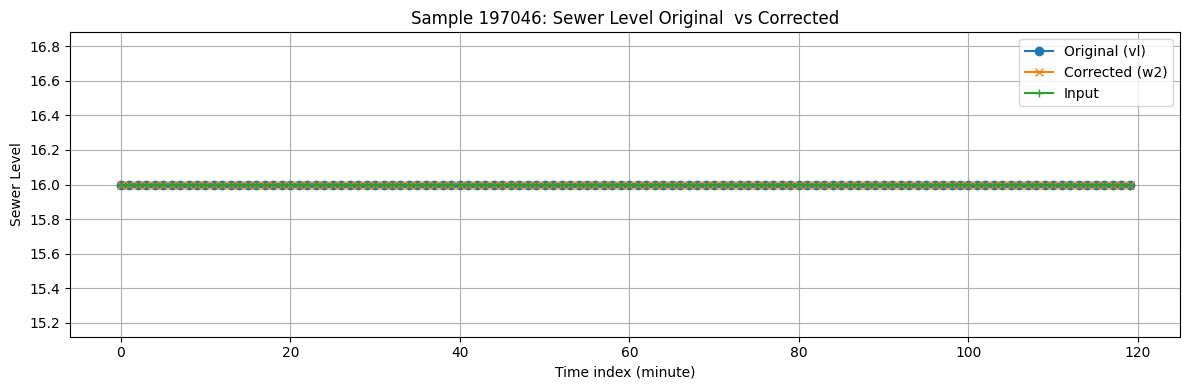

<Figure size 640x480 with 0 Axes>

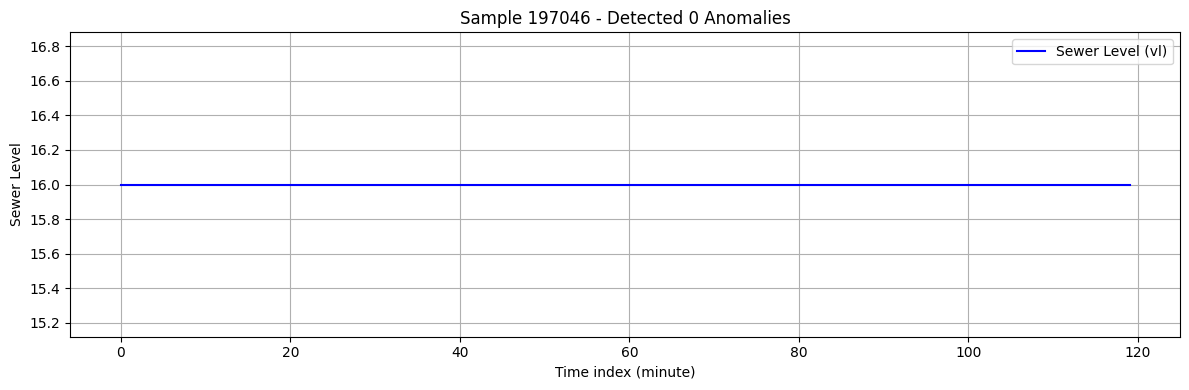

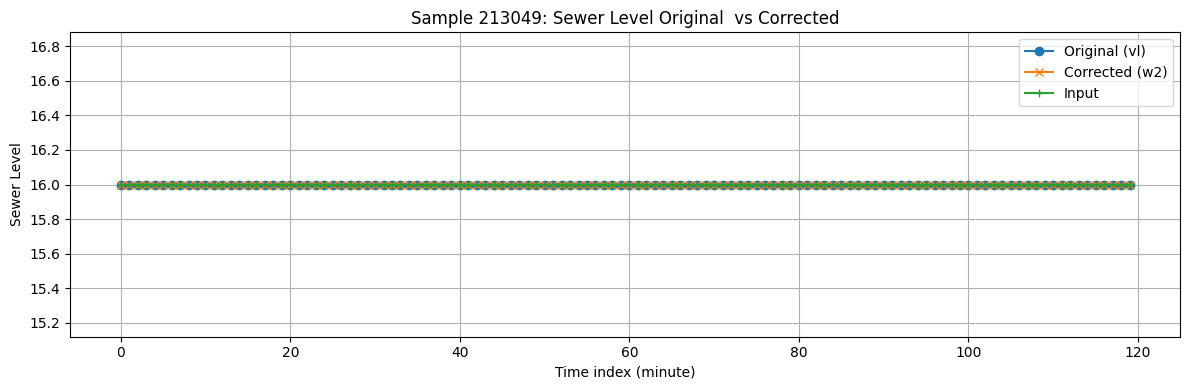

<Figure size 640x480 with 0 Axes>

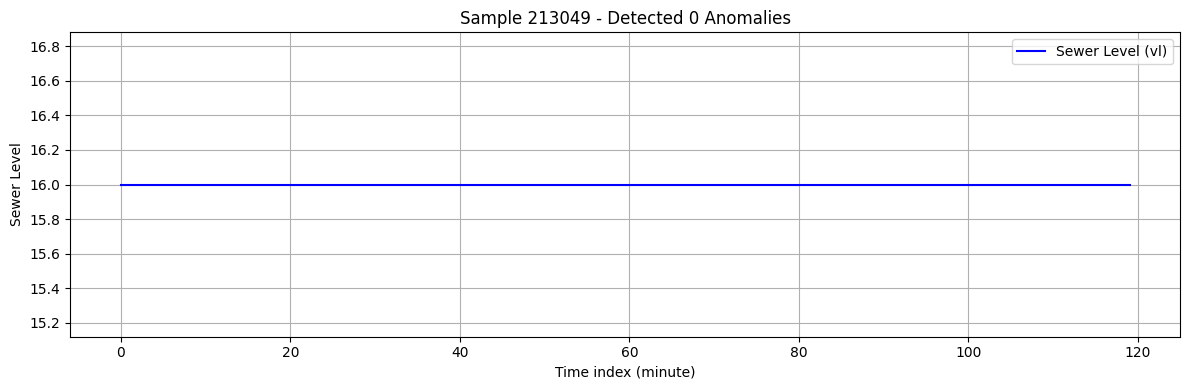

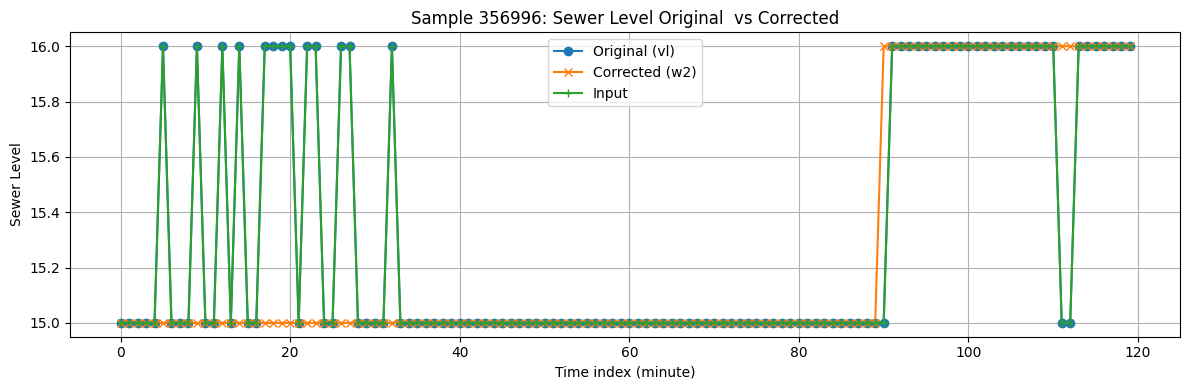

<Figure size 640x480 with 0 Axes>

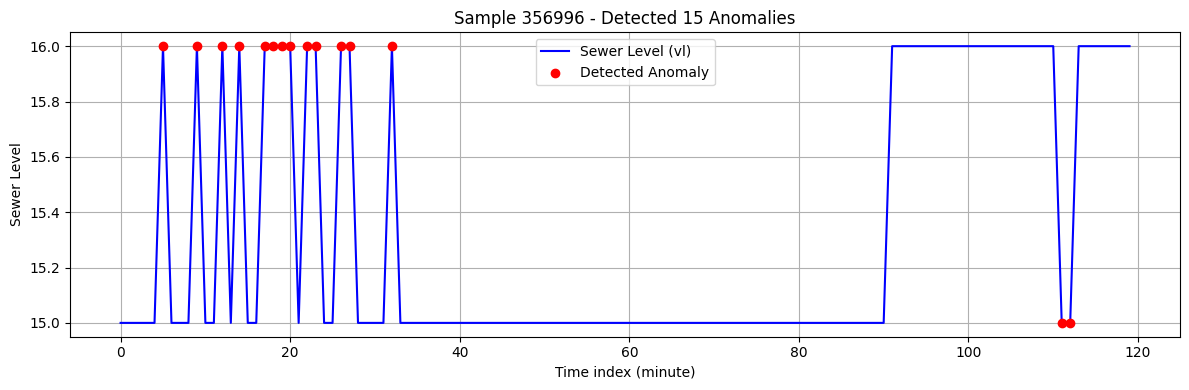

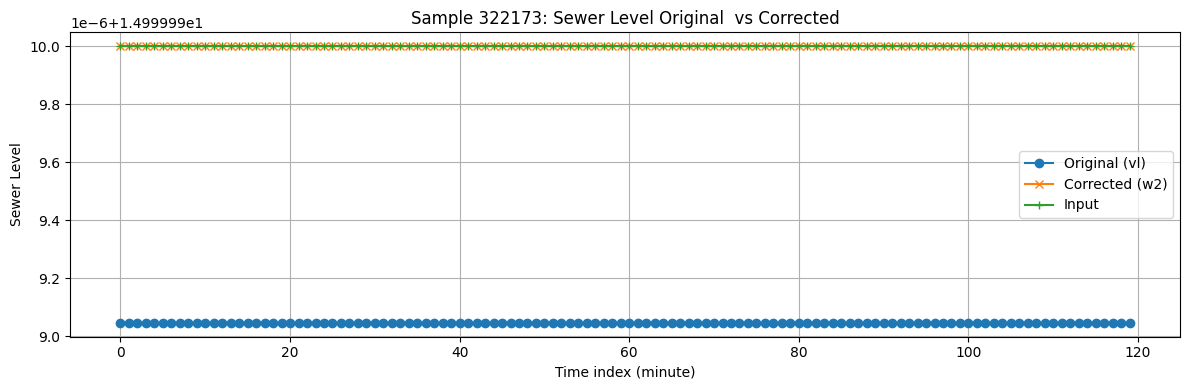

<Figure size 640x480 with 0 Axes>

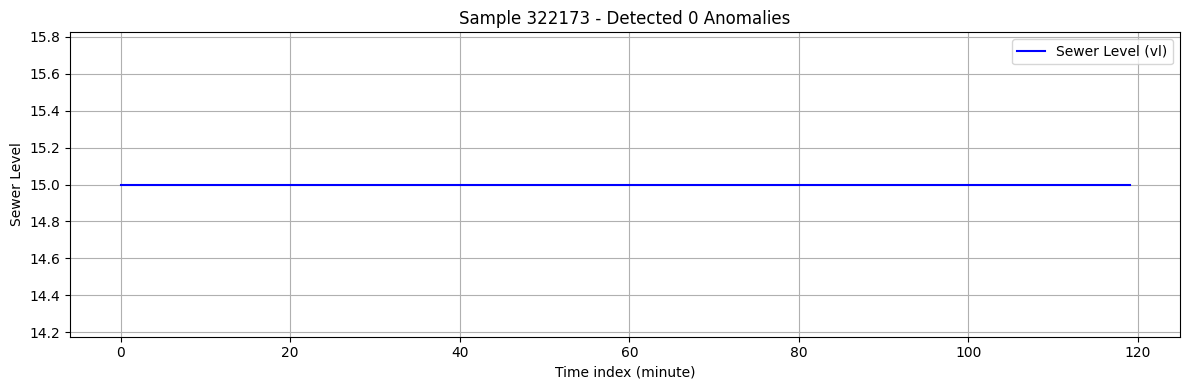

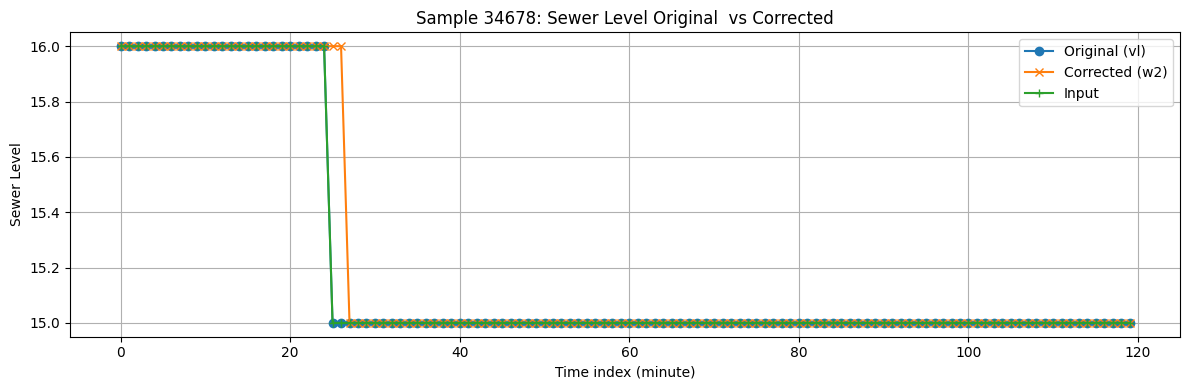

<Figure size 640x480 with 0 Axes>

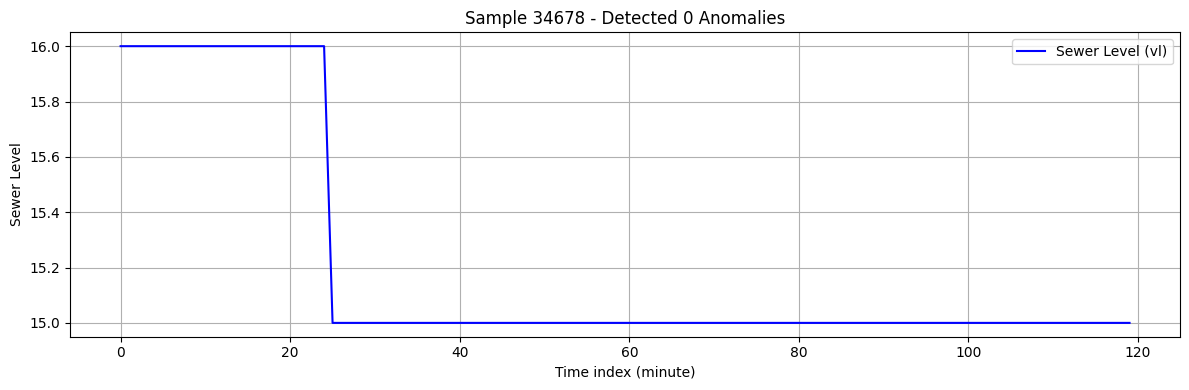

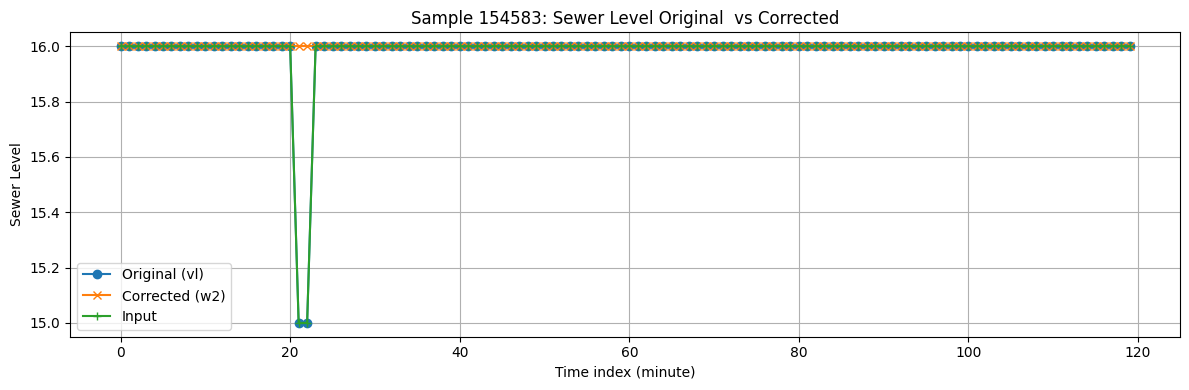

<Figure size 640x480 with 0 Axes>

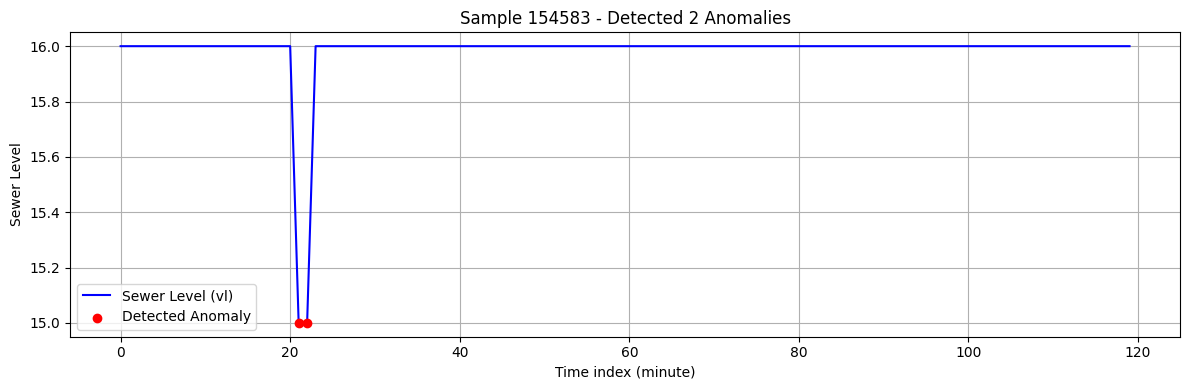

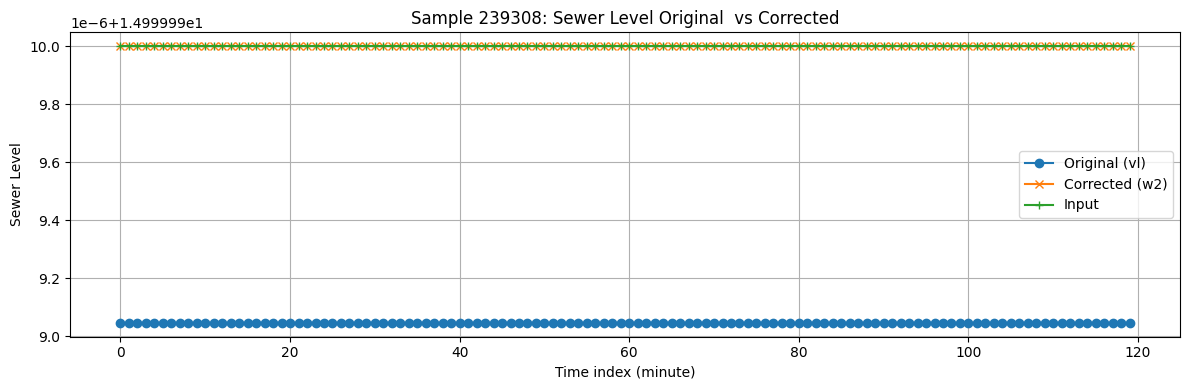

<Figure size 640x480 with 0 Axes>

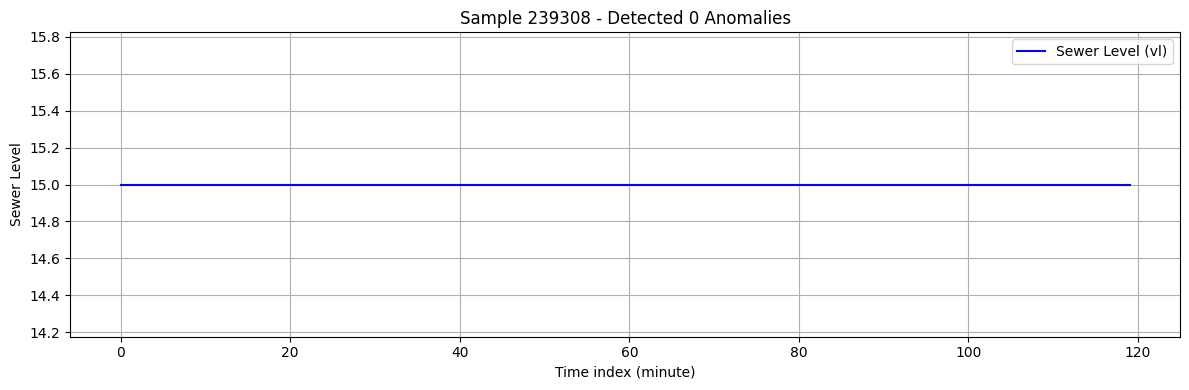

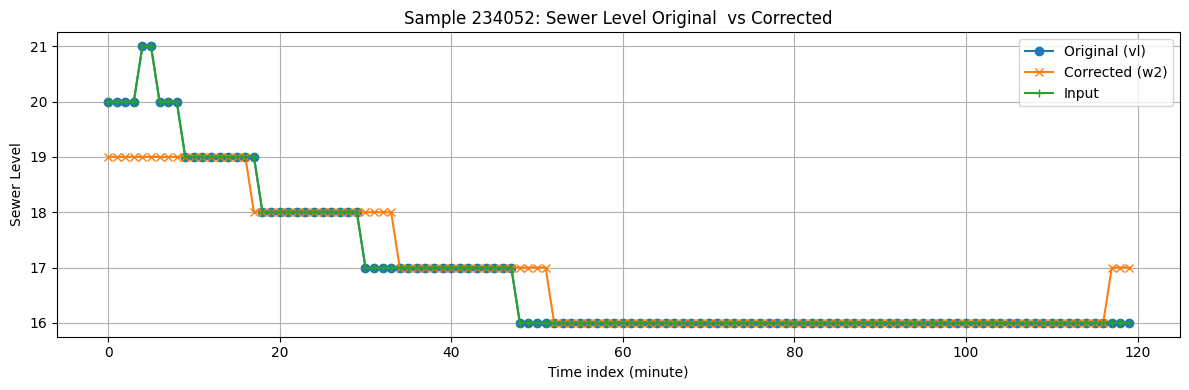

<Figure size 640x480 with 0 Axes>

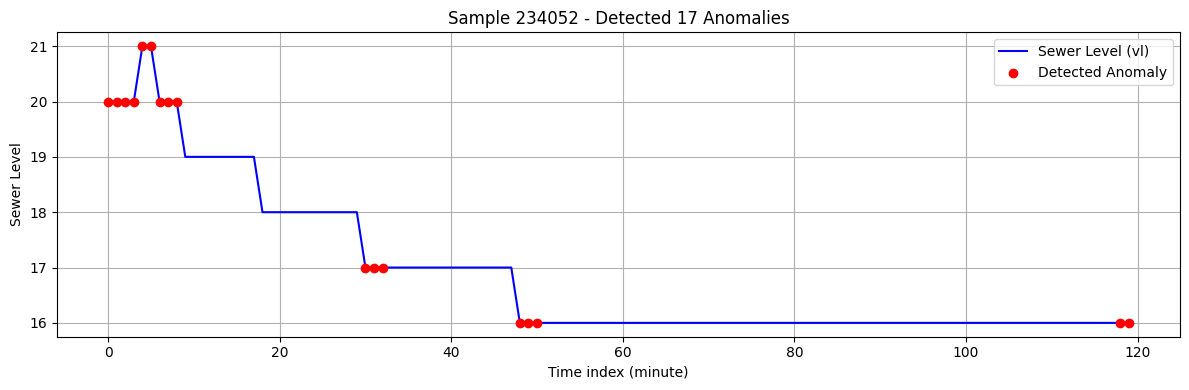

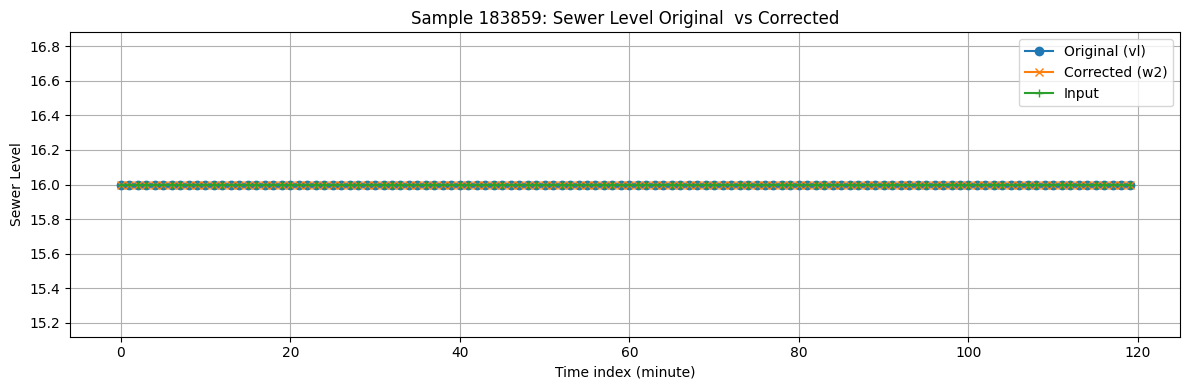

<Figure size 640x480 with 0 Axes>

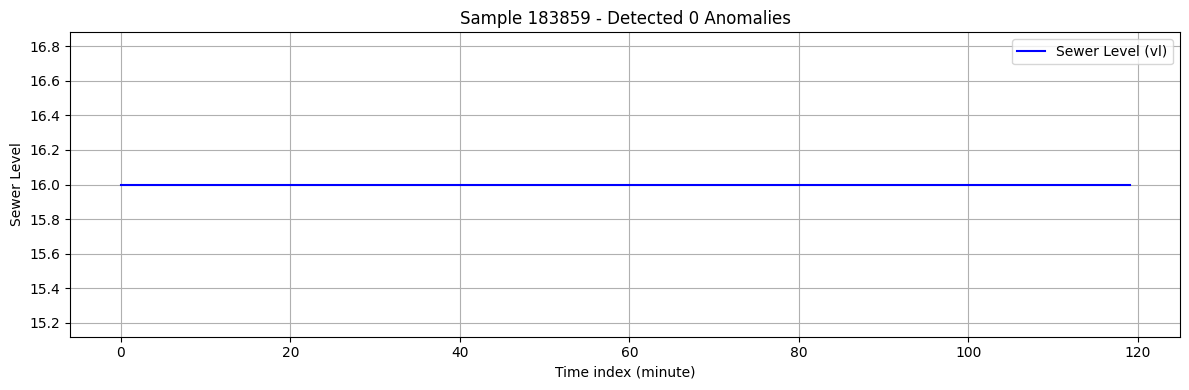

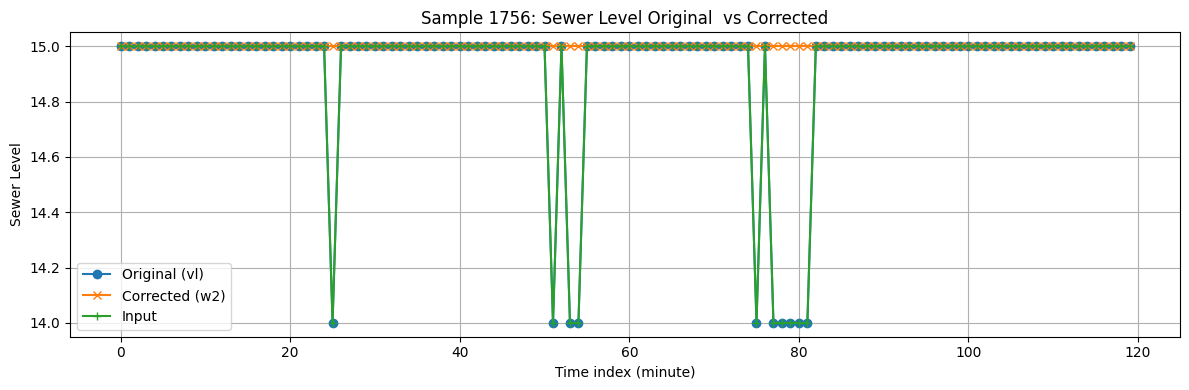

<Figure size 640x480 with 0 Axes>

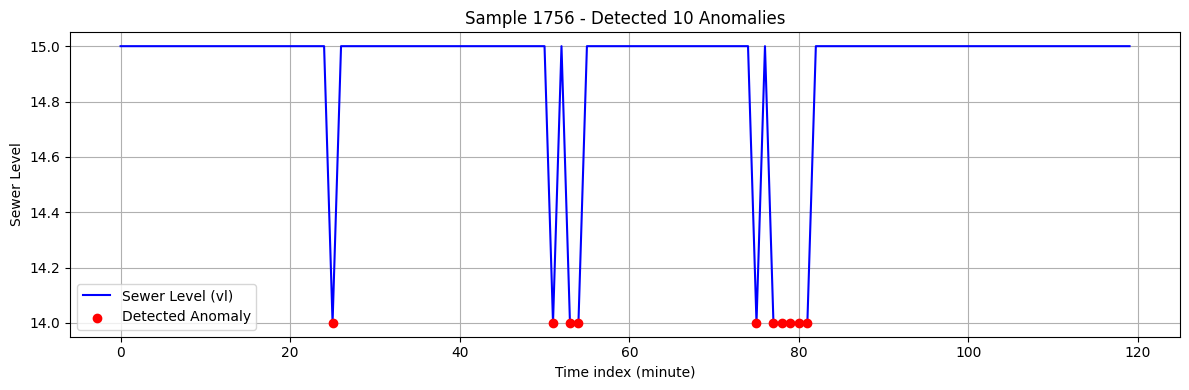

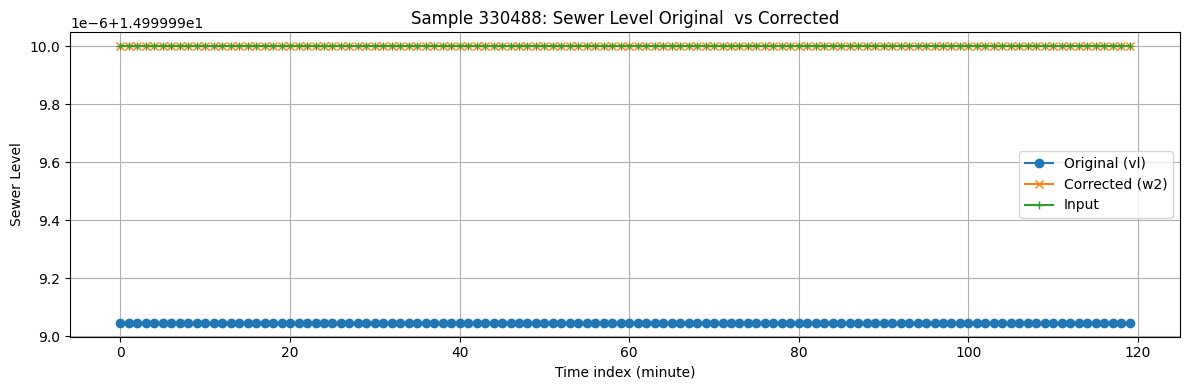

<Figure size 640x480 with 0 Axes>

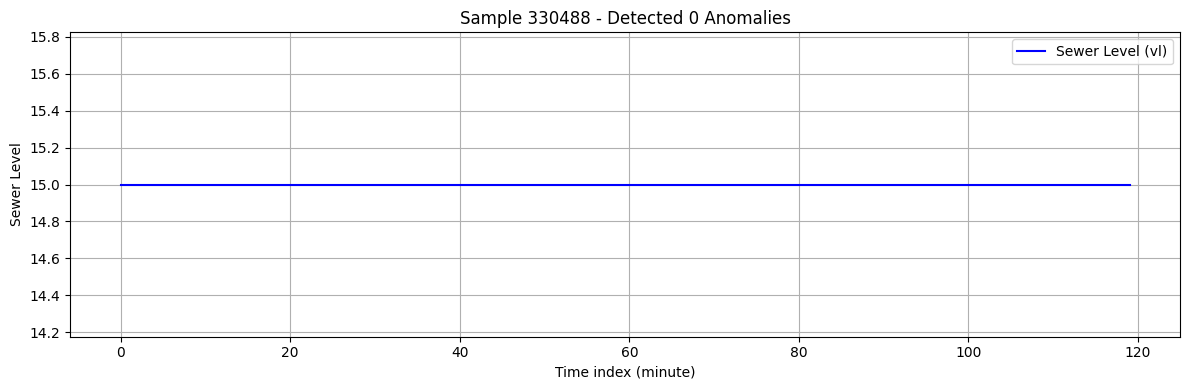

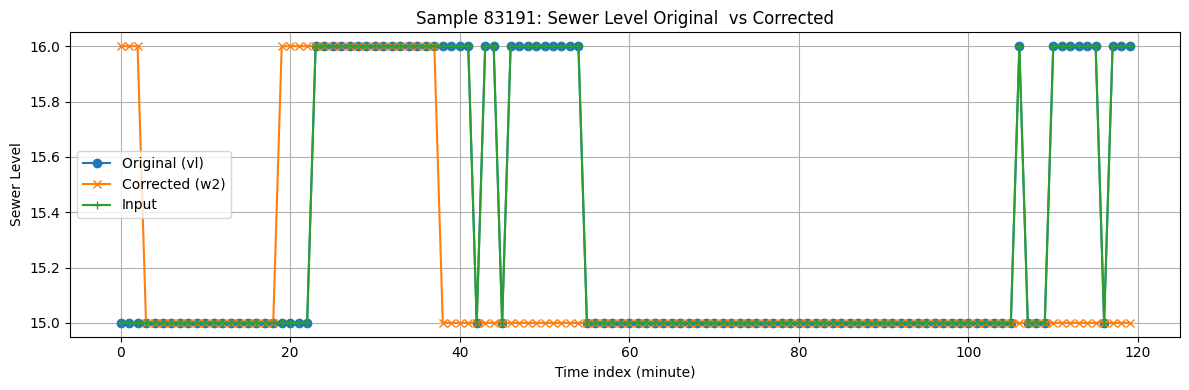

<Figure size 640x480 with 0 Axes>

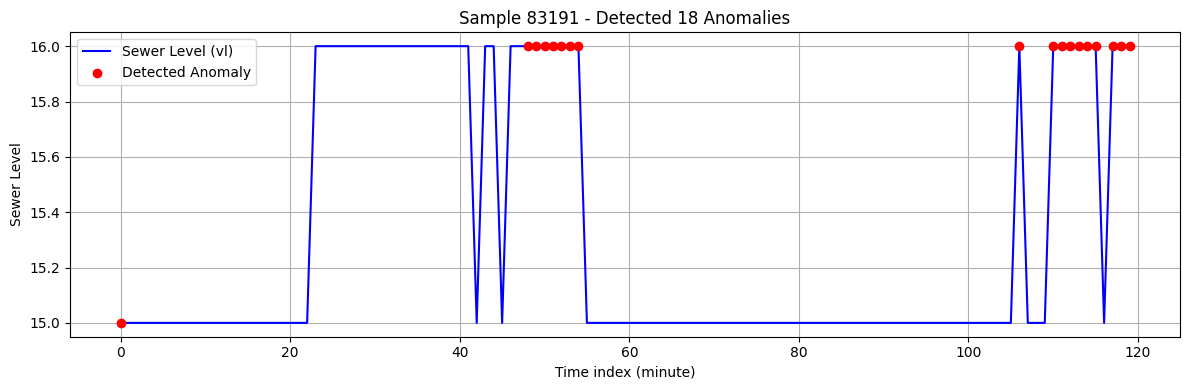

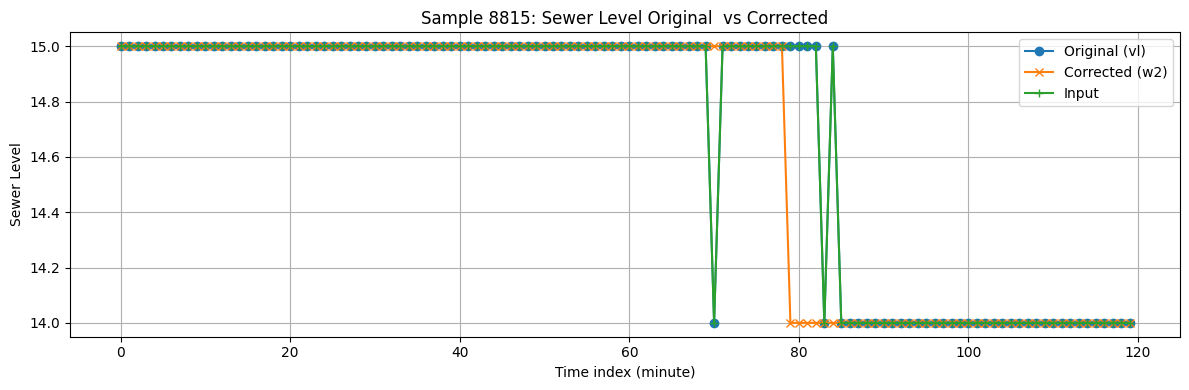

<Figure size 640x480 with 0 Axes>

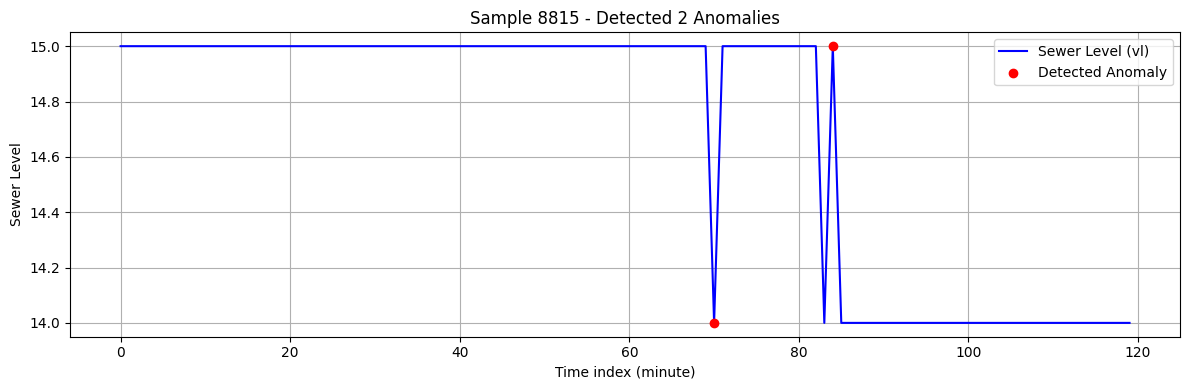

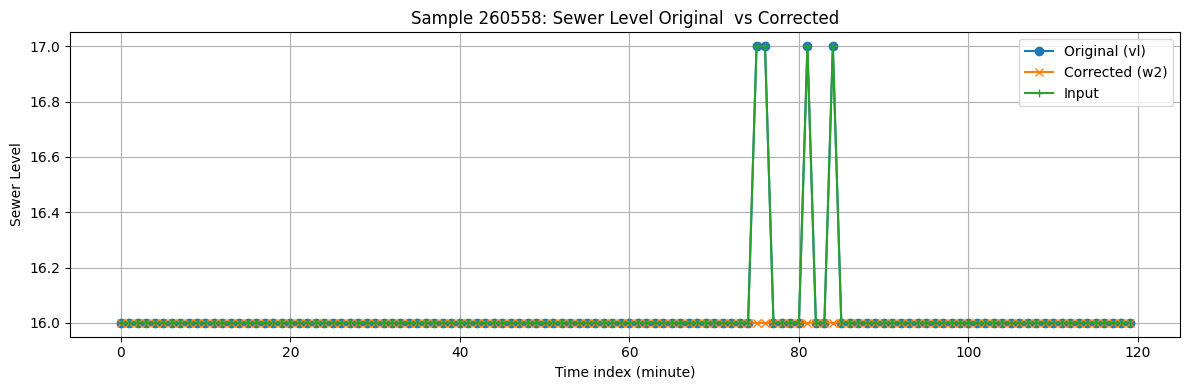

<Figure size 640x480 with 0 Axes>

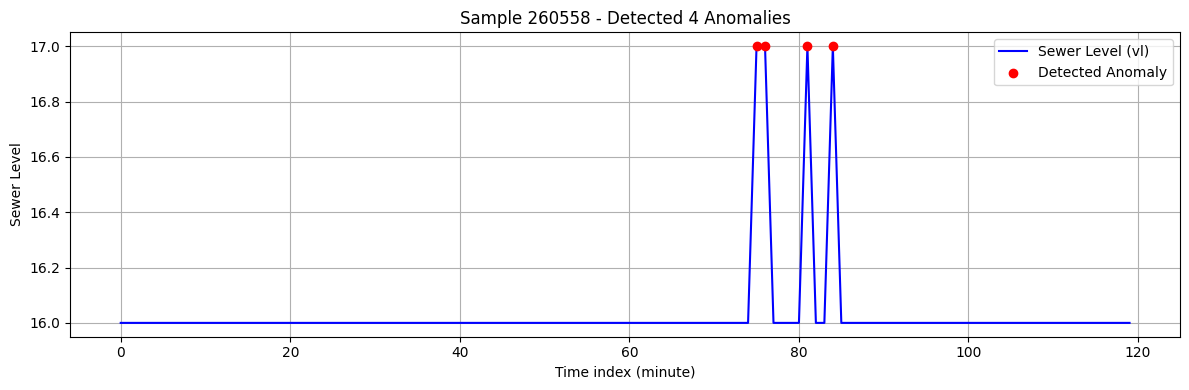

In [50]:
import random
sav_path = f'./imgs/USAD_{seq_len}/'
for i in range(50):
    n = random.randint(0,len(val_seq))
    plot_corrected_vs_original(sewer_lv, corrected_norm, input_seq, sav_path, sample_idx=n)
    plot_anomalies_on_timeseries(sewer_lv, anomaly_flags, sav_path, sample_idx=n)

In [40]:

summarize_anomaly_statistics(errors, anomaly_flags, original_values=original_vl)

📊 이상치 탐지 통계 요약
- 총 관측 시점 수: 47505600
- 이상치 시점 수: 3944584
- 이상치 비율: 8.30%
- 이상치 평균 오차: 0.000189
- 정상 평균 오차: 0.000005
- 결측치(Missing) 시점 수: 0


In [41]:
def apply_anomaly_mask(original_seq, anomaly_flags, mask_value=np.nan, target_idx=1):
    """
    original_seq: numpy array [N, T, D] - 원본 시계열 데이터
    anomaly_flags: bool array [N, T] - 이상치 위치 (True: 이상치)
    mask_value: 마스킹할 값 (기본값: np.nan)
    target_idx: 마스킹할 변수 index (기본: 관로수위 = 1)
    return: 마스킹된 시계열 데이터 (복사본)
    """
    masked_seq = original_seq.copy()
    masked_seq[:, :, target_idx][anomaly_flags] = mask_value
    return masked_seq

In [42]:
masked_seq = apply_anomaly_mask(original_seq.numpy(), anomaly_flags, mask_value=np.nan, target_idx=1)
